In [181]:
import sys, os
sys.path.append('/home/A00512318/TCN')
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from TCN.mnist_pixel.model import TCN
import numpy as np
import random

In [182]:
from torchvision import datasets, transforms

def data_generator(root, batch_size):
    train_set = datasets.FashionMNIST(root=root, train=True, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))
    test_set = datasets.FashionMNIST(root=root, train=False, download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))
                              ]))

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)
    return train_loader, test_loader

In [323]:
def trainTCN(epoch):
    global steps
    train_loss = 0
    model.train()
    mult = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.view(-1, input_channels, seq_length)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        if parameters['clip'] > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), parameters['clip'])
        optimizer.step()
        train_loss += loss.item()
#         train_losses_[epoch-1][mult*batch_indx + batch_indx] += train_loss
        steps += seq_length
        if batch_idx > 0 and batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tSteps: {}'.format(
                epoch, batch_idx * parameters['batch_size'], len(train_loader.dataset),
                100. * batch_idx / len(train_loader), train_loss/log_interval, steps))
            train_losses_[epoch-1].append(train_loss/log_interval)
            train_loss = 0  

In [324]:
def testTCN():
    test_loss = 0
    correct = 0
    correct_class = list(0. for i in range(10))
    correct_total = list(0. for i in range(10))
#     conf_matrix = [[] for i in range(len(classes))]
    tot = 0
    with torch.no_grad():
        for data, target in test_loader:
            if cuda:
                data, target = data.to(device), target.to(device)
            data = data.view(-1, input_channels, seq_length)
            if permutee:
                data = data[:, :, permute]
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            _, pred = torch.max(output, 1)
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
#             print(len(pred), pred.shape)
            c = (pred == target).squeeze()
            
#             tot += 1
            
#             if tot != 313:
#             for i in range(len(test_loader.dataset) // batch_size):
# #                     print(pred[i], target.data.view_as(pred)[i])
#                 print(i)
#                 label = pred[i]
#                 if (pred[i] == target.data.view_as(pred)[i]):
#                     correct_class[label] += c[i].item()
#                 correct_total[label] += 1
                    
                
#     print(tot)
#     for i in range(10):
#         print('Accuracy of %5s : %2d %%' % (
#             classes[i], 100 * correct_class[i] / correct_total[i]))

    test_loss /= len(test_loader.dataset)
#     print(correct.item())
    accuracies_.append(correct.item() / 10000.)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss

In [183]:
import pickle

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Print model's state_dict
def models_state_dict(model):
    print("Model's state_dict:")
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
def optimizers_state_dict():
    print("Optimizer's state_dict:")
    for var_name in optimizer.state_dict():
        print(var_name, "\t", optimizer.state_dict()[var_name])

def save_obj(obj, name):
    with open('{0}.pkl'.format(name), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('{0}.pkl'.format(name), 'rb') as f:
        return pickle.load(f)

In [154]:
def set_parameters(num_models=50, batch_size=[32, 64, 128], dropout=[0., 1],
                  clip=[0.3, 1.], lr=[-6, 1], ksize=[3, 8], levels=[3, 9],
                  optim='Adam', nhid=[15, 30], epochs=[1, 6]):

    seen_hyper = set()
    list_parameters = [{} for i in range(0, num_models)]
    for i in range(0, num_models):
        while(True):
            list_parameters[i]['batch_size'] = random.choice(batch_size)
            list_parameters[i]['dropout'] = np.random.uniform(dropout[0], dropout[1])
            list_parameters[i]['clip'] = np.random.uniform(clip[0], clip[1])
            list_parameters[i]['lr'] = pow(10, np.random.uniform(lr[0], lr[1]))
            list_parameters[i]['ksize'] = np.random.randint(ksize[0], ksize[1])
            list_parameters[i]['levels'] = np.random.randint(levels[0], levels[1])
            list_parameters[i]['optim'] = optim
            list_parameters[i]['nhid'] = np.random.randint(nhid[0], nhid[1])
            list_parameters[i]['epochs'] = np.random.randint(epochs[0], epochs[1])
            k = "".join(str(v) + '_' for k, v in list_parameters[i].items())
            if k not in seen_hyper:
                seen_hyper.add(k)
                break
    return list_parameters
# save_obj(list_parameters, 'list_parameters')
# [param for param in list_parameters]

In [309]:
def show_models_results(scores, list_params):
    for i, score in enumerate(scores):
        print("Model {0}".format(i + 1))
        print("Parameters => {0}".format(list_params[i]))
        print("Inference accuracy => {0}".format(score['accuracies'][-1]))
        print("Train losses => {0}".format([losses for losses in score['train_losses']]))
#         print("Test losses => {0}".format([losses for losses in score['test_losses']]))    

In [237]:
scores = load_obj('scores')
print(scores)
# list_params = load_obj('list_parameters')
# for i, score in enumerate(scores):
# #     print("Model {0}".format(i))
# #     print("Parameters => {0}".format(list_params[i]))
# #     print("Inference accuracy => {0}".format(score['accuracies'][-1]))
# #     print("Train losses => {0}".format([losses[0][0] for losses in score['train_losses']]))
# #     print("Test losses => {0}".format([losses for losses in score['test_losses']]))    
#     if score['accuracies'][-1] > .30:
#         print(list_params[i])

[{'accuracies': [0.5171, 0.5372, 0.5382], 'train_losses': [[(1.941871075630188, 79184), (1.4955438113212585, 157584), (1.408286967277527, 235984), (1.3624919015169143, 314384), (1.3169889706373215, 392784), (1.281186329126358, 471184), (1.2888981223106384, 549584), (1.26920367538929, 627984), (1.2430176949501037, 706384), (1.2260433262586594, 784784), (1.214490032196045, 863184), (1.2391440910100937, 941584), (1.1990722328424455, 1019984), (1.2132999122142791, 1098384), (1.2291193056106566, 1176784), (1.191657447218895, 1255184), (1.175863465666771, 1333584), (1.1975769793987274, 1411984)], [(1.2142995083332062, 1549184), (1.1744008302688598, 1627584), (1.1951773065328597, 1705984), (1.1652913373708724, 1784384), (1.1801029545068742, 1862784), (1.1628421694040298, 1941184), (1.1644994908571242, 2019584), (1.1798642480373382, 2097984), (1.1618990325927734, 2176384), (1.152829493880272, 2254784), (1.155299060344696, 2333184), (1.1752663165330888, 2411584), (1.1443875181674956, 2489984), 

In [286]:
import matplotlib.pyplot as plt

def plotTrainLosses(scores = [], fsize = 18, xlabel = '', ylabel = '', title = '', axis = [0, 5, 0, 3]):
    fig, ax = plt.subplots(figsize=(fsize, fsize))

    for i, score in enumerate(scores):
#         all_losses = [sum(losses)/len(score['train_losses']) for losses in score['train_losses']]
        ax.plot(score['train_losses'], label="TCN {0}".format(i + 1))
#         print(all_losses)

    legend = ax.legend()
    legend.get_frame().set_facecolor('C0')
    plt.axis(axis)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

[(1.941871075630188, 79184), (1.4955438113212585, 157584), (1.408286967277527, 235984), (1.3624919015169143, 314384), (1.3169889706373215, 392784), (1.281186329126358, 471184), (1.2888981223106384, 549584), (1.26920367538929, 627984), (1.2430176949501037, 706384), (1.2260433262586594, 784784), (1.214490032196045, 863184), (1.2391440910100937, 941584), (1.1990722328424455, 1019984), (1.2132999122142791, 1098384), (1.2291193056106566, 1176784), (1.191657447218895, 1255184), (1.175863465666771, 1333584), (1.1975769793987274, 1411984)]


TypeError: unsupported operand type(s) for +: 'int' and 'tuple'

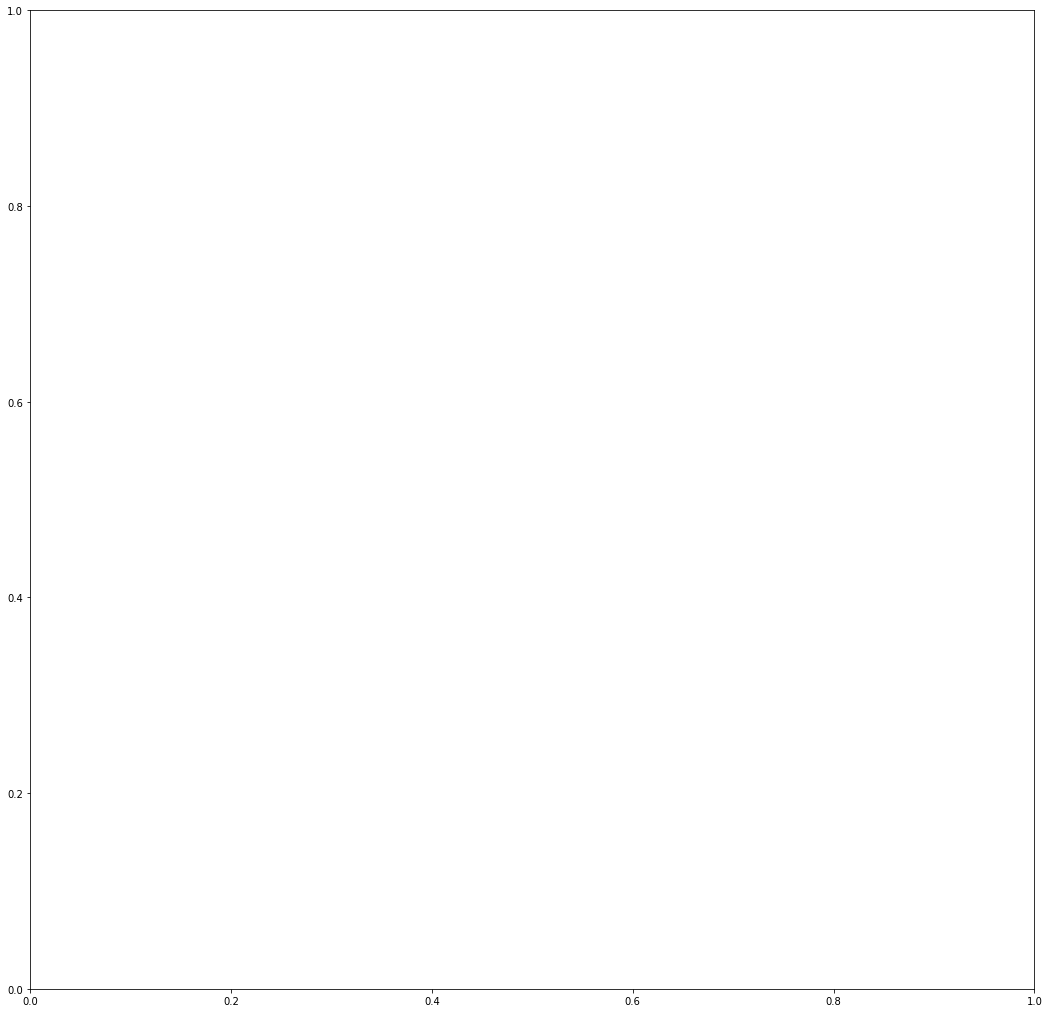

In [280]:
print(scores[0]['train_losses'][0])
plotTrainLosses(scores, fsize=18, xlabel='epochs', ylabel='testing average loss', 
                title='Testing average loss of 50 TCNs (random search on hyperparameters)')


TypeError: unsupported operand type(s) for +: 'int' and 'tuple'

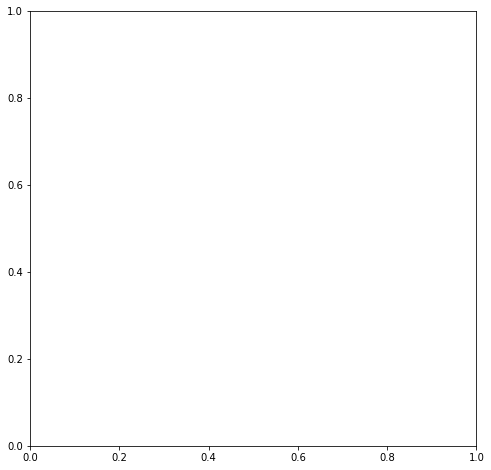

In [244]:
plotTrainLosses([s for s in scores if s['accuracies'][-1] > .30], 
                fsize=8, xlabel='epochs', ylabel='testing average loss', 
                title='Testing average loss of "best" TCNs (random search on hyperparameters)')

In [137]:
def plotAccuracies(scores, fsize=7, acc_score=.20, xlabel='epochs', 
                    ylabel='inference accuracy', axis=[1, 5, 0, 1],
                    title='Inference accuracy of "best" TCNs (random search for hyperparameters)'):
    
    fig, ax = plt.subplots(figsize=(fsize, fsize))

    for i, score in enumerate(scores):
        if score['accuracies'][-1] >= acc_score:
            ax.plot([s for s in score['accuracies']], label="TCN {0}".format(i + 1))

    legend = ax.legend()
    legend.get_frame().set_facecolor('C0')
    plt.axis(axis)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

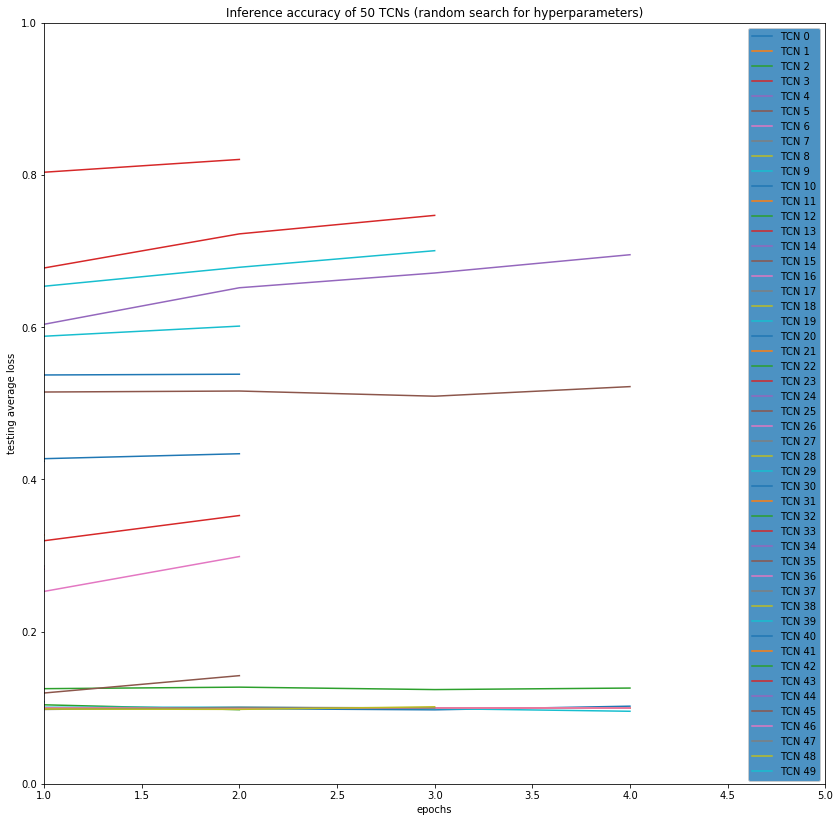

In [371]:
plotAccuracies(scores, fsize=14, acc_score=0.0, xlabel='epochs', 
               ylabel='testing average loss', axis=[1, 5, 0, 1],
                title='Inference accuracy of 50 TCNs (random search for hyperparameters)')

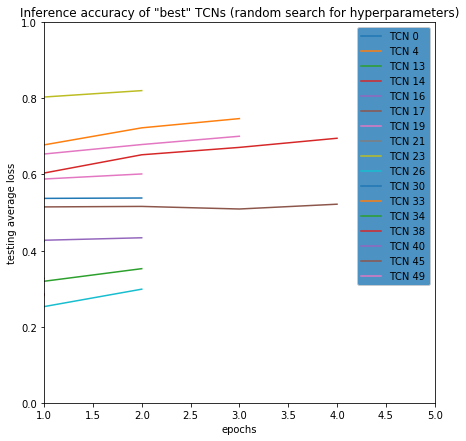

In [376]:
plotAccuracies(scores, fsize=7, acc_score=0.25, xlabel='epochs', 
               ylabel='testing average loss', axis=[1, 5, 0, 1],
                title='Inference accuracy of "best" TCNs (random search for hyperparameters)')

### Train "best" TCNs for 15 epochs

In [377]:
def newParams(list_params, scores, acc_score):
    new_params = []
    for i, score in enumerate(scores):
        if score['accuracies'][-1] > acc_score:
            new_params.append(list_params[i])
    return new_params

In [205]:
best_params = newParams(list_params, scores, .25)
print(len(best_params))
best_params

NameError: name 'newParams' is not defined

In [210]:

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# input_channels = 1 # just one for the image
# classes = ('T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
# n_classes = len(classes) # 10 classes for fashion-mnist
# log_interval = 100
# seed = 1111
# torch.manual_seed(seed)
# permutee = False
# input_channels = 1
# seq_length = int(784 / input_channels)
# steps = 0
# cuda = True
# scores = []
# epochs = 15

# for model_indx, parameters in enumerate(o = load_obj('./best_models/scores')
# # list_params = load_obj('list_parameters')
# for i, score in enumerate(o):
#     print("Model {0}".format(i))
#     print("Parameters => {0}".format(new_params[i]))
#     print("Inference accuracy => {0}".format(score['accuracies'][-1]))
#     print("Train losses => {0}".format([losses[0][0] for losses in score['train_losses']]))
#     print("Test losses => {0}".format([losses for losses in score['test_losses']]))    ):
#     print(parameters)    
# #     permute = torch.Tensor(np.random.permutation(784).astype(np.float64)).long()
# #     permute = permute.to(device)

#     train_loader, test_loader = data_generator('../data/fashion_mnist', parameters['batch_size'])

#     model = TCN(input_channels, n_classes, hidden_units=parameters['nhid'], levels=parameters['levels'], kernel_size=parameters['ksize'], dropout=parameters['dropout'])
#     model = nn.DataParallel(model)
#     model.to(device)
#     steps = 0
# #     print(count_parameters(model))
#     lr = parameters['lr']
#     optimizer = getattr(optim, parameters['optim'])(model.parameters(), lr=lr)
#     accuracies_ = []
#     train_losses_ = [[] for i in range(0, epochs)]
#     test_losses_ = []
#     file_name = './best_models/model_{0}.pt'.format(model_indx)

#     for epoch in range(1, epochs+1):
#         trainTCN(epoch)
#         test_losses_.append(testTCN())
#         if epoch % 5 == 0: 
#             print('Saving checkpoint for model.....')
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.module.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'train_losses': train_losses_,
#                 'test_losses': test_losses_,
#                 'accuracies': accuracies_,
#                 'curr_lr': lr,
#             }, file_name)
#         if epoch % 10 == 0:
#             lr /= 10
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr
#     torch.save(model.module.state_dict(), file_name)
#     scores.append({
#         'accuracies': accuracies_,
#         'train_losses': train_losses_,
#         'test_losses': test_losses_,
#     })
#     print('Saved as %s' % file_name) 
# save_obj(scores, './best_models/scores')

{'batch_size': 32, 'dropout': 0.34326058921300817, 'clip': 0.6493645456943744, 'lr': 0.005133514861863708, 'ksize': 5, 'levels': 4, 'optim': 'Adam', 'nhid': 19, 'epochs': 3}
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.941871	Steps: 79184
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.495635	Steps: 157584
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.407324	Steps: 235984
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.361328	Steps: 314384
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.314796	Steps: 392784
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.291283	Steps: 471184
Train Epoch: 1 [22400/60000 (37%)]	Loss: 1.285782	Steps: 549584
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.275486	Steps: 627984
Train Epoch: 1 [28800/60000 (48%)]	Loss: 1.241878	Steps: 706384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.240752	Steps: 784784
Train Epoch: 1 [35200/60000 (59%)]	Loss: 1.222007	Steps: 863184
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.239850	Steps: 941584
Train Epoch: 1 [41600/60000 (69%)]	Loss: 1.208550	Steps: 101998

/home/A00512318/anaconda3/envs/tcn/lib/python3.7/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 1.1933, Accuracy: 5154/10000 (51%)

Train Epoch: 2 [3200/60000 (5%)]	Loss: 1.218590	Steps: 1549184
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.189260	Steps: 1627584
Train Epoch: 2 [9600/60000 (16%)]	Loss: 1.201981	Steps: 1705984
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.180803	Steps: 1784384
Train Epoch: 2 [16000/60000 (27%)]	Loss: 1.186010	Steps: 1862784
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.164821	Steps: 1941184
Train Epoch: 2 [22400/60000 (37%)]	Loss: 1.179749	Steps: 2019584
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.185011	Steps: 2097984
Train Epoch: 2 [28800/60000 (48%)]	Loss: 1.173689	Steps: 2176384
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.150887	Steps: 2254784
Train Epoch: 2 [35200/60000 (59%)]	Loss: 1.164464	Steps: 2333184
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.178726	Steps: 2411584
Train Epoch: 2 [41600/60000 (69%)]	Loss: 1.158313	Steps: 2489984
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.168626	Steps: 2568384
Train Epoch: 2 [48000/60000 (80%)

Train Epoch: 8 [41600/60000 (69%)]	Loss: 1.092498	Steps: 11309984
Train Epoch: 8 [44800/60000 (75%)]	Loss: 1.090113	Steps: 11388384
Train Epoch: 8 [48000/60000 (80%)]	Loss: 1.105445	Steps: 11466784
Train Epoch: 8 [51200/60000 (85%)]	Loss: 1.087109	Steps: 11545184
Train Epoch: 8 [54400/60000 (91%)]	Loss: 1.074918	Steps: 11623584
Train Epoch: 8 [57600/60000 (96%)]	Loss: 1.075484	Steps: 11701984

Test set: Average loss: 1.0858, Accuracy: 5648/10000 (56%)

Train Epoch: 9 [3200/60000 (5%)]	Loss: 1.109350	Steps: 11839184
Train Epoch: 9 [6400/60000 (11%)]	Loss: 1.093201	Steps: 11917584
Train Epoch: 9 [9600/60000 (16%)]	Loss: 1.096974	Steps: 11995984
Train Epoch: 9 [12800/60000 (21%)]	Loss: 1.087602	Steps: 12074384
Train Epoch: 9 [16000/60000 (27%)]	Loss: 1.099326	Steps: 12152784
Train Epoch: 9 [19200/60000 (32%)]	Loss: 1.070044	Steps: 12231184
Train Epoch: 9 [22400/60000 (37%)]	Loss: 1.089708	Steps: 12309584
Train Epoch: 9 [25600/60000 (43%)]	Loss: 1.073504	Steps: 12387984
Train Epoch: 9 [288

Train Epoch: 15 [12800/60000 (21%)]	Loss: 1.033091	Steps: 20894384
Train Epoch: 15 [16000/60000 (27%)]	Loss: 1.065954	Steps: 20972784
Train Epoch: 15 [19200/60000 (32%)]	Loss: 1.052800	Steps: 21051184
Train Epoch: 15 [22400/60000 (37%)]	Loss: 1.043155	Steps: 21129584
Train Epoch: 15 [25600/60000 (43%)]	Loss: 1.021210	Steps: 21207984
Train Epoch: 15 [28800/60000 (48%)]	Loss: 1.034047	Steps: 21286384
Train Epoch: 15 [32000/60000 (53%)]	Loss: 1.015305	Steps: 21364784
Train Epoch: 15 [35200/60000 (59%)]	Loss: 1.031040	Steps: 21443184
Train Epoch: 15 [38400/60000 (64%)]	Loss: 1.060639	Steps: 21521584
Train Epoch: 15 [41600/60000 (69%)]	Loss: 1.054310	Steps: 21599984
Train Epoch: 15 [44800/60000 (75%)]	Loss: 1.055400	Steps: 21678384
Train Epoch: 15 [48000/60000 (80%)]	Loss: 1.043206	Steps: 21756784
Train Epoch: 15 [51200/60000 (85%)]	Loss: 1.049134	Steps: 21835184
Train Epoch: 15 [54400/60000 (91%)]	Loss: 1.021195	Steps: 21913584
Train Epoch: 15 [57600/60000 (96%)]	Loss: 1.013606	Steps: 2199

Train Epoch: 3 [51200/60000 (85%)]	Loss: 1.699558	Steps: 8389584
Train Epoch: 3 [52800/60000 (88%)]	Loss: 1.693510	Steps: 8467984
Train Epoch: 3 [54400/60000 (91%)]	Loss: 1.717071	Steps: 8546384
Train Epoch: 3 [56000/60000 (93%)]	Loss: 1.692180	Steps: 8624784
Train Epoch: 3 [57600/60000 (96%)]	Loss: 1.702440	Steps: 8703184
Train Epoch: 3 [59200/60000 (99%)]	Loss: 1.704890	Steps: 8781584

Test set: Average loss: 1.7027, Accuracy: 3299/10000 (32%)

Train Epoch: 4 [1600/60000 (3%)]	Loss: 1.717047	Steps: 8899184
Train Epoch: 4 [3200/60000 (5%)]	Loss: 1.703481	Steps: 8977584
Train Epoch: 4 [4800/60000 (8%)]	Loss: 1.655719	Steps: 9055984
Train Epoch: 4 [6400/60000 (11%)]	Loss: 1.683490	Steps: 9134384
Train Epoch: 4 [8000/60000 (13%)]	Loss: 1.708444	Steps: 9212784
Train Epoch: 4 [9600/60000 (16%)]	Loss: 1.704995	Steps: 9291184
Train Epoch: 4 [11200/60000 (19%)]	Loss: 1.669180	Steps: 9369584
Train Epoch: 4 [12800/60000 (21%)]	Loss: 1.668280	Steps: 9447984
Train Epoch: 4 [14400/60000 (24%)]	Los

Train Epoch: 7 [8000/60000 (13%)]	Loss: 1.427178	Steps: 18032784
Train Epoch: 7 [9600/60000 (16%)]	Loss: 1.425737	Steps: 18111184
Train Epoch: 7 [11200/60000 (19%)]	Loss: 1.414985	Steps: 18189584
Train Epoch: 7 [12800/60000 (21%)]	Loss: 1.427980	Steps: 18267984
Train Epoch: 7 [14400/60000 (24%)]	Loss: 1.424689	Steps: 18346384
Train Epoch: 7 [16000/60000 (27%)]	Loss: 1.410525	Steps: 18424784
Train Epoch: 7 [17600/60000 (29%)]	Loss: 1.417898	Steps: 18503184
Train Epoch: 7 [19200/60000 (32%)]	Loss: 1.427904	Steps: 18581584
Train Epoch: 7 [20800/60000 (35%)]	Loss: 1.442207	Steps: 18659984
Train Epoch: 7 [22400/60000 (37%)]	Loss: 1.378841	Steps: 18738384
Train Epoch: 7 [24000/60000 (40%)]	Loss: 1.406548	Steps: 18816784
Train Epoch: 7 [25600/60000 (43%)]	Loss: 1.430122	Steps: 18895184
Train Epoch: 7 [27200/60000 (45%)]	Loss: 1.419556	Steps: 18973584
Train Epoch: 7 [28800/60000 (48%)]	Loss: 1.423919	Steps: 19051984
Train Epoch: 7 [30400/60000 (51%)]	Loss: 1.410837	Steps: 19130384
Train Epoch:

Train Epoch: 10 [25600/60000 (43%)]	Loss: 1.333624	Steps: 27715184
Train Epoch: 10 [27200/60000 (45%)]	Loss: 1.276230	Steps: 27793584
Train Epoch: 10 [28800/60000 (48%)]	Loss: 1.282705	Steps: 27871984
Train Epoch: 10 [30400/60000 (51%)]	Loss: 1.320760	Steps: 27950384
Train Epoch: 10 [32000/60000 (53%)]	Loss: 1.283057	Steps: 28028784
Train Epoch: 10 [33600/60000 (56%)]	Loss: 1.289071	Steps: 28107184
Train Epoch: 10 [35200/60000 (59%)]	Loss: 1.302230	Steps: 28185584
Train Epoch: 10 [36800/60000 (61%)]	Loss: 1.299125	Steps: 28263984
Train Epoch: 10 [38400/60000 (64%)]	Loss: 1.315420	Steps: 28342384
Train Epoch: 10 [40000/60000 (67%)]	Loss: 1.267189	Steps: 28420784
Train Epoch: 10 [41600/60000 (69%)]	Loss: 1.300095	Steps: 28499184
Train Epoch: 10 [43200/60000 (72%)]	Loss: 1.307735	Steps: 28577584
Train Epoch: 10 [44800/60000 (75%)]	Loss: 1.269471	Steps: 28655984
Train Epoch: 10 [46400/60000 (77%)]	Loss: 1.292731	Steps: 28734384
Train Epoch: 10 [48000/60000 (80%)]	Loss: 1.316959	Steps: 2881

Train Epoch: 13 [40000/60000 (67%)]	Loss: 1.255063	Steps: 37240784
Train Epoch: 13 [41600/60000 (69%)]	Loss: 1.260104	Steps: 37319184
Train Epoch: 13 [43200/60000 (72%)]	Loss: 1.280517	Steps: 37397584
Train Epoch: 13 [44800/60000 (75%)]	Loss: 1.258036	Steps: 37475984
Train Epoch: 13 [46400/60000 (77%)]	Loss: 1.285724	Steps: 37554384
Train Epoch: 13 [48000/60000 (80%)]	Loss: 1.306071	Steps: 37632784
Train Epoch: 13 [49600/60000 (83%)]	Loss: 1.214792	Steps: 37711184
Train Epoch: 13 [51200/60000 (85%)]	Loss: 1.274729	Steps: 37789584
Train Epoch: 13 [52800/60000 (88%)]	Loss: 1.239861	Steps: 37867984
Train Epoch: 13 [54400/60000 (91%)]	Loss: 1.247479	Steps: 37946384
Train Epoch: 13 [56000/60000 (93%)]	Loss: 1.265113	Steps: 38024784
Train Epoch: 13 [57600/60000 (96%)]	Loss: 1.282232	Steps: 38103184
Train Epoch: 13 [59200/60000 (99%)]	Loss: 1.267846	Steps: 38181584

Test set: Average loss: 1.2789, Accuracy: 4906/10000 (49%)

Train Epoch: 14 [1600/60000 (3%)]	Loss: 1.304634	Steps: 38299184
Tra

Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.453264	Steps: 2509584
Train Epoch: 1 [52800/60000 (88%)]	Loss: 1.397027	Steps: 2587984
Train Epoch: 1 [54400/60000 (91%)]	Loss: 1.372952	Steps: 2666384
Train Epoch: 1 [56000/60000 (93%)]	Loss: 1.343581	Steps: 2744784
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.368663	Steps: 2823184
Train Epoch: 1 [59200/60000 (99%)]	Loss: 1.333258	Steps: 2901584

Test set: Average loss: 1.3238, Accuracy: 5158/10000 (51%)

Train Epoch: 2 [1600/60000 (3%)]	Loss: 1.332858	Steps: 3019184
Train Epoch: 2 [3200/60000 (5%)]	Loss: 1.294826	Steps: 3097584
Train Epoch: 2 [4800/60000 (8%)]	Loss: 1.277106	Steps: 3175984
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.284544	Steps: 3254384
Train Epoch: 2 [8000/60000 (13%)]	Loss: 1.299981	Steps: 3332784
Train Epoch: 2 [9600/60000 (16%)]	Loss: 1.282645	Steps: 3411184
Train Epoch: 2 [11200/60000 (19%)]	Loss: 1.226472	Steps: 3489584
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.265563	Steps: 3567984
Train Epoch: 2 [14400/60000 (24%)]	Los

Train Epoch: 5 [11200/60000 (19%)]	Loss: 0.815693	Steps: 12309584
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.856846	Steps: 12387984
Train Epoch: 5 [14400/60000 (24%)]	Loss: 0.848715	Steps: 12466384
Train Epoch: 5 [16000/60000 (27%)]	Loss: 0.859608	Steps: 12544784
Train Epoch: 5 [17600/60000 (29%)]	Loss: 0.857557	Steps: 12623184
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.877096	Steps: 12701584
Train Epoch: 5 [20800/60000 (35%)]	Loss: 0.896117	Steps: 12779984
Train Epoch: 5 [22400/60000 (37%)]	Loss: 0.825871	Steps: 12858384
Train Epoch: 5 [24000/60000 (40%)]	Loss: 0.830919	Steps: 12936784
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.858095	Steps: 13015184
Train Epoch: 5 [27200/60000 (45%)]	Loss: 0.801420	Steps: 13093584
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.836865	Steps: 13171984
Train Epoch: 5 [30400/60000 (51%)]	Loss: 0.842280	Steps: 13250384
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.816096	Steps: 13328784
Train Epoch: 5 [33600/60000 (56%)]	Loss: 0.816495	Steps: 13407184
Train Epoc

Train Epoch: 8 [28800/60000 (48%)]	Loss: 0.725592	Steps: 21991984
Train Epoch: 8 [30400/60000 (51%)]	Loss: 0.724181	Steps: 22070384
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.686473	Steps: 22148784
Train Epoch: 8 [33600/60000 (56%)]	Loss: 0.674998	Steps: 22227184
Train Epoch: 8 [35200/60000 (59%)]	Loss: 0.714265	Steps: 22305584
Train Epoch: 8 [36800/60000 (61%)]	Loss: 0.747755	Steps: 22383984
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.683030	Steps: 22462384
Train Epoch: 8 [40000/60000 (67%)]	Loss: 0.674333	Steps: 22540784
Train Epoch: 8 [41600/60000 (69%)]	Loss: 0.671130	Steps: 22619184
Train Epoch: 8 [43200/60000 (72%)]	Loss: 0.714076	Steps: 22697584
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.693008	Steps: 22775984
Train Epoch: 8 [46400/60000 (77%)]	Loss: 0.737657	Steps: 22854384
Train Epoch: 8 [48000/60000 (80%)]	Loss: 0.690412	Steps: 22932784
Train Epoch: 8 [49600/60000 (83%)]	Loss: 0.657490	Steps: 23011184
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.710235	Steps: 23089584
Train Epoc

Train Epoch: 11 [44800/60000 (75%)]	Loss: 0.645775	Steps: 31595984
Train Epoch: 11 [46400/60000 (77%)]	Loss: 0.672769	Steps: 31674384
Train Epoch: 11 [48000/60000 (80%)]	Loss: 0.624227	Steps: 31752784
Train Epoch: 11 [49600/60000 (83%)]	Loss: 0.607895	Steps: 31831184
Train Epoch: 11 [51200/60000 (85%)]	Loss: 0.623287	Steps: 31909584
Train Epoch: 11 [52800/60000 (88%)]	Loss: 0.657829	Steps: 31987984
Train Epoch: 11 [54400/60000 (91%)]	Loss: 0.652788	Steps: 32066384
Train Epoch: 11 [56000/60000 (93%)]	Loss: 0.651271	Steps: 32144784
Train Epoch: 11 [57600/60000 (96%)]	Loss: 0.643807	Steps: 32223184
Train Epoch: 11 [59200/60000 (99%)]	Loss: 0.624377	Steps: 32301584

Test set: Average loss: 0.6616, Accuracy: 7614/10000 (76%)

Train Epoch: 12 [1600/60000 (3%)]	Loss: 0.620788	Steps: 32419184
Train Epoch: 12 [3200/60000 (5%)]	Loss: 0.633619	Steps: 32497584
Train Epoch: 12 [4800/60000 (8%)]	Loss: 0.600190	Steps: 32575984
Train Epoch: 12 [6400/60000 (11%)]	Loss: 0.646396	Steps: 32654384
Train Ep

Train Epoch: 14 [59200/60000 (99%)]	Loss: 0.626423	Steps: 41121584

Test set: Average loss: 0.6501, Accuracy: 7609/10000 (76%)

Train Epoch: 15 [1600/60000 (3%)]	Loss: 0.625223	Steps: 41239184
Train Epoch: 15 [3200/60000 (5%)]	Loss: 0.640629	Steps: 41317584
Train Epoch: 15 [4800/60000 (8%)]	Loss: 0.574668	Steps: 41395984
Train Epoch: 15 [6400/60000 (11%)]	Loss: 0.644570	Steps: 41474384
Train Epoch: 15 [8000/60000 (13%)]	Loss: 0.626431	Steps: 41552784
Train Epoch: 15 [9600/60000 (16%)]	Loss: 0.637540	Steps: 41631184
Train Epoch: 15 [11200/60000 (19%)]	Loss: 0.587324	Steps: 41709584
Train Epoch: 15 [12800/60000 (21%)]	Loss: 0.641759	Steps: 41787984
Train Epoch: 15 [14400/60000 (24%)]	Loss: 0.631543	Steps: 41866384
Train Epoch: 15 [16000/60000 (27%)]	Loss: 0.660726	Steps: 41944784
Train Epoch: 15 [17600/60000 (29%)]	Loss: 0.655009	Steps: 42023184
Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.665979	Steps: 42101584
Train Epoch: 15 [20800/60000 (35%)]	Loss: 0.670672	Steps: 42179984
Train Epoc

Train Epoch: 3 [12800/60000 (21%)]	Loss: 1.099343	Steps: 6507984
Train Epoch: 3 [14400/60000 (24%)]	Loss: 1.021945	Steps: 6586384
Train Epoch: 3 [16000/60000 (27%)]	Loss: 1.099577	Steps: 6664784
Train Epoch: 3 [17600/60000 (29%)]	Loss: 1.086198	Steps: 6743184
Train Epoch: 3 [19200/60000 (32%)]	Loss: 1.117944	Steps: 6821584
Train Epoch: 3 [20800/60000 (35%)]	Loss: 1.099433	Steps: 6899984
Train Epoch: 3 [22400/60000 (37%)]	Loss: 1.048307	Steps: 6978384
Train Epoch: 3 [24000/60000 (40%)]	Loss: 1.068642	Steps: 7056784
Train Epoch: 3 [25600/60000 (43%)]	Loss: 1.107439	Steps: 7135184
Train Epoch: 3 [27200/60000 (45%)]	Loss: 1.045212	Steps: 7213584
Train Epoch: 3 [28800/60000 (48%)]	Loss: 1.075152	Steps: 7291984
Train Epoch: 3 [30400/60000 (51%)]	Loss: 1.087751	Steps: 7370384
Train Epoch: 3 [32000/60000 (53%)]	Loss: 1.072963	Steps: 7448784
Train Epoch: 3 [33600/60000 (56%)]	Loss: 1.061855	Steps: 7527184
Train Epoch: 3 [35200/60000 (59%)]	Loss: 1.039064	Steps: 7605584
Train Epoch: 3 [36800/600

Train Epoch: 6 [30400/60000 (51%)]	Loss: 1.023402	Steps: 16190384
Train Epoch: 6 [32000/60000 (53%)]	Loss: 1.025037	Steps: 16268784
Train Epoch: 6 [33600/60000 (56%)]	Loss: 0.990106	Steps: 16347184
Train Epoch: 6 [35200/60000 (59%)]	Loss: 1.015850	Steps: 16425584
Train Epoch: 6 [36800/60000 (61%)]	Loss: 1.065608	Steps: 16503984
Train Epoch: 6 [38400/60000 (64%)]	Loss: 1.001056	Steps: 16582384
Train Epoch: 6 [40000/60000 (67%)]	Loss: 1.018631	Steps: 16660784
Train Epoch: 6 [41600/60000 (69%)]	Loss: 1.018462	Steps: 16739184
Train Epoch: 6 [43200/60000 (72%)]	Loss: 0.992802	Steps: 16817584
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.973167	Steps: 16895984
Train Epoch: 6 [46400/60000 (77%)]	Loss: 1.080626	Steps: 16974384
Train Epoch: 6 [48000/60000 (80%)]	Loss: 1.009634	Steps: 17052784
Train Epoch: 6 [49600/60000 (83%)]	Loss: 0.984421	Steps: 17131184
Train Epoch: 6 [51200/60000 (85%)]	Loss: 1.046688	Steps: 17209584
Train Epoch: 6 [52800/60000 (88%)]	Loss: 1.057715	Steps: 17287984
Train Epoc

Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.961838	Steps: 25872784
Train Epoch: 9 [49600/60000 (83%)]	Loss: 0.952039	Steps: 25951184
Train Epoch: 9 [51200/60000 (85%)]	Loss: 1.045786	Steps: 26029584
Train Epoch: 9 [52800/60000 (88%)]	Loss: 1.018078	Steps: 26107984
Train Epoch: 9 [54400/60000 (91%)]	Loss: 1.000222	Steps: 26186384
Train Epoch: 9 [56000/60000 (93%)]	Loss: 0.979529	Steps: 26264784
Train Epoch: 9 [57600/60000 (96%)]	Loss: 1.028454	Steps: 26343184
Train Epoch: 9 [59200/60000 (99%)]	Loss: 0.983473	Steps: 26421584

Test set: Average loss: 0.9768, Accuracy: 6377/10000 (63%)

Train Epoch: 10 [1600/60000 (3%)]	Loss: 0.980736	Steps: 26539184
Train Epoch: 10 [3200/60000 (5%)]	Loss: 0.963625	Steps: 26617584
Train Epoch: 10 [4800/60000 (8%)]	Loss: 0.958393	Steps: 26695984
Train Epoch: 10 [6400/60000 (11%)]	Loss: 1.020408	Steps: 26774384
Train Epoch: 10 [8000/60000 (13%)]	Loss: 1.002409	Steps: 26852784
Train Epoch: 10 [9600/60000 (16%)]	Loss: 0.995184	Steps: 26931184
Train Epoch: 10 [1

Train Epoch: 13 [1600/60000 (3%)]	Loss: 0.930714	Steps: 35359184
Train Epoch: 13 [3200/60000 (5%)]	Loss: 0.899509	Steps: 35437584
Train Epoch: 13 [4800/60000 (8%)]	Loss: 0.888220	Steps: 35515984
Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.907970	Steps: 35594384
Train Epoch: 13 [8000/60000 (13%)]	Loss: 0.941276	Steps: 35672784
Train Epoch: 13 [9600/60000 (16%)]	Loss: 0.924564	Steps: 35751184
Train Epoch: 13 [11200/60000 (19%)]	Loss: 0.854274	Steps: 35829584
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.872634	Steps: 35907984
Train Epoch: 13 [14400/60000 (24%)]	Loss: 0.900503	Steps: 35986384
Train Epoch: 13 [16000/60000 (27%)]	Loss: 0.925110	Steps: 36064784
Train Epoch: 13 [17600/60000 (29%)]	Loss: 0.886589	Steps: 36143184
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.939244	Steps: 36221584
Train Epoch: 13 [20800/60000 (35%)]	Loss: 0.900800	Steps: 36299984
Train Epoch: 13 [22400/60000 (37%)]	Loss: 0.869485	Steps: 36378384
Train Epoch: 13 [24000/60000 (40%)]	Loss: 0.881269	Steps: 36456784
Trai

Train Epoch: 1 [11200/60000 (19%)]	Loss: 1.920244	Steps: 549584
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.888148	Steps: 627984
Train Epoch: 1 [14400/60000 (24%)]	Loss: 1.879335	Steps: 706384
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.849318	Steps: 784784
Train Epoch: 1 [17600/60000 (29%)]	Loss: 1.913902	Steps: 863184
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.910268	Steps: 941584
Train Epoch: 1 [20800/60000 (35%)]	Loss: 1.880346	Steps: 1019984
Train Epoch: 1 [22400/60000 (37%)]	Loss: 1.847215	Steps: 1098384
Train Epoch: 1 [24000/60000 (40%)]	Loss: 1.864220	Steps: 1176784
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.892541	Steps: 1255184
Train Epoch: 1 [27200/60000 (45%)]	Loss: 1.886498	Steps: 1333584
Train Epoch: 1 [28800/60000 (48%)]	Loss: 1.871511	Steps: 1411984
Train Epoch: 1 [30400/60000 (51%)]	Loss: 1.899808	Steps: 1490384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.889165	Steps: 1568784
Train Epoch: 1 [33600/60000 (56%)]	Loss: 1.858497	Steps: 1647184
Train Epoch: 1 [35200/60000 (59

Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.783341	Steps: 10388784
Train Epoch: 4 [33600/60000 (56%)]	Loss: 1.803570	Steps: 10467184
Train Epoch: 4 [35200/60000 (59%)]	Loss: 1.800552	Steps: 10545584
Train Epoch: 4 [36800/60000 (61%)]	Loss: 1.796598	Steps: 10623984
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.741922	Steps: 10702384
Train Epoch: 4 [40000/60000 (67%)]	Loss: 1.727125	Steps: 10780784
Train Epoch: 4 [41600/60000 (69%)]	Loss: 1.805017	Steps: 10859184
Train Epoch: 4 [43200/60000 (72%)]	Loss: 1.827694	Steps: 10937584
Train Epoch: 4 [44800/60000 (75%)]	Loss: 1.779628	Steps: 11015984
Train Epoch: 4 [46400/60000 (77%)]	Loss: 1.809472	Steps: 11094384
Train Epoch: 4 [48000/60000 (80%)]	Loss: 1.799782	Steps: 11172784
Train Epoch: 4 [49600/60000 (83%)]	Loss: 1.741867	Steps: 11251184
Train Epoch: 4 [51200/60000 (85%)]	Loss: 1.827458	Steps: 11329584
Train Epoch: 4 [52800/60000 (88%)]	Loss: 1.765999	Steps: 11407984
Train Epoch: 4 [54400/60000 (91%)]	Loss: 1.739739	Steps: 11486384
Train Epoc

Train Epoch: 7 [49600/60000 (83%)]	Loss: 1.741716	Steps: 20071184
Train Epoch: 7 [51200/60000 (85%)]	Loss: 1.783833	Steps: 20149584
Train Epoch: 7 [52800/60000 (88%)]	Loss: 1.754140	Steps: 20227984
Train Epoch: 7 [54400/60000 (91%)]	Loss: 1.743186	Steps: 20306384
Train Epoch: 7 [56000/60000 (93%)]	Loss: 1.799814	Steps: 20384784
Train Epoch: 7 [57600/60000 (96%)]	Loss: 1.781674	Steps: 20463184
Train Epoch: 7 [59200/60000 (99%)]	Loss: 1.784345	Steps: 20541584

Test set: Average loss: 1.7627, Accuracy: 3280/10000 (32%)

Train Epoch: 8 [1600/60000 (3%)]	Loss: 1.754037	Steps: 20659184
Train Epoch: 8 [3200/60000 (5%)]	Loss: 1.763936	Steps: 20737584
Train Epoch: 8 [4800/60000 (8%)]	Loss: 1.716496	Steps: 20815984
Train Epoch: 8 [6400/60000 (11%)]	Loss: 1.767284	Steps: 20894384
Train Epoch: 8 [8000/60000 (13%)]	Loss: 1.738446	Steps: 20972784
Train Epoch: 8 [9600/60000 (16%)]	Loss: 1.769673	Steps: 21051184
Train Epoch: 8 [11200/60000 (19%)]	Loss: 1.790803	Steps: 21129584
Train Epoch: 8 [12800/60

Train Epoch: 11 [4800/60000 (8%)]	Loss: 1.735549	Steps: 29635984
Train Epoch: 11 [6400/60000 (11%)]	Loss: 1.713860	Steps: 29714384
Train Epoch: 11 [8000/60000 (13%)]	Loss: 1.731040	Steps: 29792784
Train Epoch: 11 [9600/60000 (16%)]	Loss: 1.744730	Steps: 29871184
Train Epoch: 11 [11200/60000 (19%)]	Loss: 1.729292	Steps: 29949584
Train Epoch: 11 [12800/60000 (21%)]	Loss: 1.719410	Steps: 30027984
Train Epoch: 11 [14400/60000 (24%)]	Loss: 1.731534	Steps: 30106384
Train Epoch: 11 [16000/60000 (27%)]	Loss: 1.714222	Steps: 30184784
Train Epoch: 11 [17600/60000 (29%)]	Loss: 1.752551	Steps: 30263184
Train Epoch: 11 [19200/60000 (32%)]	Loss: 1.727048	Steps: 30341584
Train Epoch: 11 [20800/60000 (35%)]	Loss: 1.762973	Steps: 30419984
Train Epoch: 11 [22400/60000 (37%)]	Loss: 1.710160	Steps: 30498384
Train Epoch: 11 [24000/60000 (40%)]	Loss: 1.717703	Steps: 30576784
Train Epoch: 11 [25600/60000 (43%)]	Loss: 1.715829	Steps: 30655184
Train Epoch: 11 [27200/60000 (45%)]	Loss: 1.739508	Steps: 30733584


Train Epoch: 14 [20800/60000 (35%)]	Loss: 1.707320	Steps: 39239984
Train Epoch: 14 [22400/60000 (37%)]	Loss: 1.713105	Steps: 39318384
Train Epoch: 14 [24000/60000 (40%)]	Loss: 1.726572	Steps: 39396784
Train Epoch: 14 [25600/60000 (43%)]	Loss: 1.740454	Steps: 39475184
Train Epoch: 14 [27200/60000 (45%)]	Loss: 1.728526	Steps: 39553584
Train Epoch: 14 [28800/60000 (48%)]	Loss: 1.716686	Steps: 39631984
Train Epoch: 14 [30400/60000 (51%)]	Loss: 1.720583	Steps: 39710384
Train Epoch: 14 [32000/60000 (53%)]	Loss: 1.739449	Steps: 39788784
Train Epoch: 14 [33600/60000 (56%)]	Loss: 1.758201	Steps: 39867184
Train Epoch: 14 [35200/60000 (59%)]	Loss: 1.690572	Steps: 39945584
Train Epoch: 14 [36800/60000 (61%)]	Loss: 1.705569	Steps: 40023984
Train Epoch: 14 [38400/60000 (64%)]	Loss: 1.701110	Steps: 40102384
Train Epoch: 14 [40000/60000 (67%)]	Loss: 1.688750	Steps: 40180784
Train Epoch: 14 [41600/60000 (69%)]	Loss: 1.698599	Steps: 40259184
Train Epoch: 14 [43200/60000 (72%)]	Loss: 1.729832	Steps: 4033

Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.394040	Steps: 4304944
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.413841	Steps: 4383344

Test set: Average loss: 0.4128, Accuracy: 8467/10000 (84%)

Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.395650	Steps: 4491536
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.394789	Steps: 4569936
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.406199	Steps: 4648336
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.377827	Steps: 4726736
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.378383	Steps: 4805136
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.393801	Steps: 4883536
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.380715	Steps: 4961936
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.387406	Steps: 5040336
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.401274	Steps: 5118736

Test set: Average loss: 0.4131, Accuracy: 8503/10000 (85%)

Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.378258	Steps: 5226928
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.376216	Steps: 5305328
Train Epoch: 8 [19200/60000 (32%)]	


Test set: Average loss: 1.2630, Accuracy: 4791/10000 (47%)

Train Epoch: 4 [6400/60000 (11%)]	Loss: 1.264010	Steps: 2285360
Train Epoch: 4 [12800/60000 (21%)]	Loss: 1.254537	Steps: 2363760
Train Epoch: 4 [19200/60000 (32%)]	Loss: 1.245406	Steps: 2442160
Train Epoch: 4 [25600/60000 (43%)]	Loss: 1.234443	Steps: 2520560
Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.224767	Steps: 2598960
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.216617	Steps: 2677360
Train Epoch: 4 [44800/60000 (75%)]	Loss: 1.212435	Steps: 2755760
Train Epoch: 4 [51200/60000 (85%)]	Loss: 1.215391	Steps: 2834160
Train Epoch: 4 [57600/60000 (96%)]	Loss: 1.203680	Steps: 2912560

Test set: Average loss: 1.2067, Accuracy: 5108/10000 (51%)

Train Epoch: 5 [6400/60000 (11%)]	Loss: 1.218771	Steps: 3020752
Train Epoch: 5 [12800/60000 (21%)]	Loss: 1.218900	Steps: 3099152
Train Epoch: 5 [19200/60000 (32%)]	Loss: 1.212111	Steps: 3177552
Train Epoch: 5 [25600/60000 (43%)]	Loss: 1.195795	Steps: 3255952
Train Epoch: 5 [32000/60000 (53%)]	

Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.280552	Steps: 157584
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.161753	Steps: 235984
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.876955	Steps: 314384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.649338	Steps: 392784
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.508933	Steps: 471184
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.391683	Steps: 549584
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.297199	Steps: 627984
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.230672	Steps: 706384

Test set: Average loss: 1.1812, Accuracy: 5615/10000 (56%)

Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.169525	Steps: 814576
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.108488	Steps: 892976
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.061601	Steps: 971376
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.044198	Steps: 1049776
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.987571	Steps: 1128176
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.974722	Steps: 1206576
Train Epoch: 2 [44800/60000 (75%)]	Loss: 

Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.516910	Steps: 9452688
Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.517403	Steps: 9531088

Test set: Average loss: 0.5322, Accuracy: 8066/10000 (80%)

Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.518976	Steps: 9639280
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.517197	Steps: 9717680
Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.546258	Steps: 9796080
Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.521296	Steps: 9874480
Train Epoch: 14 [32000/60000 (53%)]	Loss: 0.505946	Steps: 9952880
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.509269	Steps: 10031280
Train Epoch: 14 [44800/60000 (75%)]	Loss: 0.501139	Steps: 10109680
Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.510100	Steps: 10188080
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.523238	Steps: 10266480

Test set: Average loss: 0.5335, Accuracy: 8076/10000 (80%)

Train Epoch: 15 [6400/60000 (11%)]	Loss: 0.503878	Steps: 10374672
Train Epoch: 15 [12800/60000 (21%)]	Loss: 0.525543	Steps: 10453072
Train Epoch: 15 

Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.737203	Steps: 7821184
Train Epoch: 6 [22400/60000 (37%)]	Loss: 0.715083	Steps: 7899584
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.702938	Steps: 7977984
Train Epoch: 6 [28800/60000 (48%)]	Loss: 0.735574	Steps: 8056384
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.725057	Steps: 8134784
Train Epoch: 6 [35200/60000 (59%)]	Loss: 0.705495	Steps: 8213184
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.718649	Steps: 8291584
Train Epoch: 6 [41600/60000 (69%)]	Loss: 0.694646	Steps: 8369984
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.700248	Steps: 8448384
Train Epoch: 6 [48000/60000 (80%)]	Loss: 0.714231	Steps: 8526784
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.694935	Steps: 8605184
Train Epoch: 6 [54400/60000 (91%)]	Loss: 0.721322	Steps: 8683584
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.712928	Steps: 8761984

Test set: Average loss: 0.7122, Accuracy: 7448/10000 (74%)

Train Epoch: 7 [3200/60000 (5%)]	Loss: 0.694117	Steps: 8899184
Train Epoch: 7 [6400/60000 (11%

Train Epoch: 12 [54400/60000 (91%)]	Loss: 0.619569	Steps: 17503584
Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.629694	Steps: 17581984

Test set: Average loss: 0.6422, Accuracy: 7727/10000 (77%)

Train Epoch: 13 [3200/60000 (5%)]	Loss: 0.624331	Steps: 17719184
Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.581219	Steps: 17797584
Train Epoch: 13 [9600/60000 (16%)]	Loss: 0.624893	Steps: 17875984
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.617527	Steps: 17954384
Train Epoch: 13 [16000/60000 (27%)]	Loss: 0.604817	Steps: 18032784
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.637347	Steps: 18111184
Train Epoch: 13 [22400/60000 (37%)]	Loss: 0.621899	Steps: 18189584
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.612162	Steps: 18267984
Train Epoch: 13 [28800/60000 (48%)]	Loss: 0.615561	Steps: 18346384
Train Epoch: 13 [32000/60000 (53%)]	Loss: 0.630819	Steps: 18424784
Train Epoch: 13 [35200/60000 (59%)]	Loss: 0.611536	Steps: 18503184
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.617504	Steps: 18581584
Train

Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.664579	Steps: 4881184
Train Epoch: 4 [22400/60000 (37%)]	Loss: 0.663527	Steps: 4959584
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.635755	Steps: 5037984
Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.652825	Steps: 5116384
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.658370	Steps: 5194784
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.607094	Steps: 5273184
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.651539	Steps: 5351584
Train Epoch: 4 [41600/60000 (69%)]	Loss: 0.616454	Steps: 5429984
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.623819	Steps: 5508384
Train Epoch: 4 [48000/60000 (80%)]	Loss: 0.636669	Steps: 5586784
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.624153	Steps: 5665184
Train Epoch: 4 [54400/60000 (91%)]	Loss: 0.642088	Steps: 5743584
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.624606	Steps: 5821984

Test set: Average loss: 0.6459, Accuracy: 7619/10000 (76%)

Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.635757	Steps: 5959184
Train Epoch: 5 [6400/60000 (11%

Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.562080	Steps: 14641984

Test set: Average loss: 0.5843, Accuracy: 7875/10000 (78%)

Saving checkpoint for model.....
Train Epoch: 11 [3200/60000 (5%)]	Loss: 0.561202	Steps: 14779184
Train Epoch: 11 [6400/60000 (11%)]	Loss: 0.499504	Steps: 14857584
Train Epoch: 11 [9600/60000 (16%)]	Loss: 0.539798	Steps: 14935984
Train Epoch: 11 [12800/60000 (21%)]	Loss: 0.533888	Steps: 15014384
Train Epoch: 11 [16000/60000 (27%)]	Loss: 0.530015	Steps: 15092784
Train Epoch: 11 [19200/60000 (32%)]	Loss: 0.536837	Steps: 15171184
Train Epoch: 11 [22400/60000 (37%)]	Loss: 0.532898	Steps: 15249584
Train Epoch: 11 [25600/60000 (43%)]	Loss: 0.517533	Steps: 15327984
Train Epoch: 11 [28800/60000 (48%)]	Loss: 0.523277	Steps: 15406384
Train Epoch: 11 [32000/60000 (53%)]	Loss: 0.531978	Steps: 15484784
Train Epoch: 11 [35200/60000 (59%)]	Loss: 0.496264	Steps: 15563184
Train Epoch: 11 [38400/60000 (64%)]	Loss: 0.519706	Steps: 15641584
Train Epoch: 11 [41600/60000 (69%)]	Los

Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.398436	Steps: 1960784
Train Epoch: 1 [41600/60000 (69%)]	Loss: 1.428647	Steps: 2039184
Train Epoch: 1 [43200/60000 (72%)]	Loss: 1.396482	Steps: 2117584
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.396468	Steps: 2195984
Train Epoch: 1 [46400/60000 (77%)]	Loss: 1.405562	Steps: 2274384
Train Epoch: 1 [48000/60000 (80%)]	Loss: 1.398236	Steps: 2352784
Train Epoch: 1 [49600/60000 (83%)]	Loss: 1.370593	Steps: 2431184
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.404411	Steps: 2509584
Train Epoch: 1 [52800/60000 (88%)]	Loss: 1.417225	Steps: 2587984
Train Epoch: 1 [54400/60000 (91%)]	Loss: 1.386712	Steps: 2666384
Train Epoch: 1 [56000/60000 (93%)]	Loss: 1.392691	Steps: 2744784
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.380101	Steps: 2823184
Train Epoch: 1 [59200/60000 (99%)]	Loss: 1.392481	Steps: 2901584

Test set: Average loss: 1.3813, Accuracy: 4323/10000 (43%)

Train Epoch: 2 [1600/60000 (3%)]	Loss: 1.454348	Steps: 3019184
Train Epoch: 2 [3200/60000 (5%)


Test set: Average loss: 1.3419, Accuracy: 4436/10000 (44%)

Train Epoch: 5 [1600/60000 (3%)]	Loss: 1.420347	Steps: 11839184
Train Epoch: 5 [3200/60000 (5%)]	Loss: 1.308752	Steps: 11917584
Train Epoch: 5 [4800/60000 (8%)]	Loss: 1.332706	Steps: 11995984
Train Epoch: 5 [6400/60000 (11%)]	Loss: 1.365067	Steps: 12074384
Train Epoch: 5 [8000/60000 (13%)]	Loss: 1.348809	Steps: 12152784
Train Epoch: 5 [9600/60000 (16%)]	Loss: 1.365074	Steps: 12231184
Train Epoch: 5 [11200/60000 (19%)]	Loss: 1.317917	Steps: 12309584
Train Epoch: 5 [12800/60000 (21%)]	Loss: 1.329851	Steps: 12387984
Train Epoch: 5 [14400/60000 (24%)]	Loss: 1.291534	Steps: 12466384
Train Epoch: 5 [16000/60000 (27%)]	Loss: 1.339461	Steps: 12544784
Train Epoch: 5 [17600/60000 (29%)]	Loss: 1.337563	Steps: 12623184
Train Epoch: 5 [19200/60000 (32%)]	Loss: 1.366599	Steps: 12701584
Train Epoch: 5 [20800/60000 (35%)]	Loss: 1.387667	Steps: 12779984
Train Epoch: 5 [22400/60000 (37%)]	Loss: 1.317128	Steps: 12858384
Train Epoch: 5 [24000/60

Train Epoch: 8 [17600/60000 (29%)]	Loss: 1.343481	Steps: 21443184
Train Epoch: 8 [19200/60000 (32%)]	Loss: 1.313291	Steps: 21521584
Train Epoch: 8 [20800/60000 (35%)]	Loss: 1.360387	Steps: 21599984
Train Epoch: 8 [22400/60000 (37%)]	Loss: 1.312227	Steps: 21678384
Train Epoch: 8 [24000/60000 (40%)]	Loss: 1.274347	Steps: 21756784
Train Epoch: 8 [25600/60000 (43%)]	Loss: 1.326519	Steps: 21835184
Train Epoch: 8 [27200/60000 (45%)]	Loss: 1.308243	Steps: 21913584
Train Epoch: 8 [28800/60000 (48%)]	Loss: 1.339029	Steps: 21991984
Train Epoch: 8 [30400/60000 (51%)]	Loss: 1.303510	Steps: 22070384
Train Epoch: 8 [32000/60000 (53%)]	Loss: 1.299295	Steps: 22148784
Train Epoch: 8 [33600/60000 (56%)]	Loss: 1.297728	Steps: 22227184
Train Epoch: 8 [35200/60000 (59%)]	Loss: 1.302642	Steps: 22305584
Train Epoch: 8 [36800/60000 (61%)]	Loss: 1.349844	Steps: 22383984
Train Epoch: 8 [38400/60000 (64%)]	Loss: 1.333253	Steps: 22462384
Train Epoch: 8 [40000/60000 (67%)]	Loss: 1.308796	Steps: 22540784
Train Epoc

Train Epoch: 11 [33600/60000 (56%)]	Loss: 1.246801	Steps: 31047184
Train Epoch: 11 [35200/60000 (59%)]	Loss: 1.278747	Steps: 31125584
Train Epoch: 11 [36800/60000 (61%)]	Loss: 1.306875	Steps: 31203984
Train Epoch: 11 [38400/60000 (64%)]	Loss: 1.297711	Steps: 31282384
Train Epoch: 11 [40000/60000 (67%)]	Loss: 1.307439	Steps: 31360784
Train Epoch: 11 [41600/60000 (69%)]	Loss: 1.236869	Steps: 31439184
Train Epoch: 11 [43200/60000 (72%)]	Loss: 1.264491	Steps: 31517584
Train Epoch: 11 [44800/60000 (75%)]	Loss: 1.282962	Steps: 31595984
Train Epoch: 11 [46400/60000 (77%)]	Loss: 1.253385	Steps: 31674384
Train Epoch: 11 [48000/60000 (80%)]	Loss: 1.289635	Steps: 31752784
Train Epoch: 11 [49600/60000 (83%)]	Loss: 1.253023	Steps: 31831184
Train Epoch: 11 [51200/60000 (85%)]	Loss: 1.268735	Steps: 31909584
Train Epoch: 11 [52800/60000 (88%)]	Loss: 1.291694	Steps: 31987984
Train Epoch: 11 [54400/60000 (91%)]	Loss: 1.237287	Steps: 32066384
Train Epoch: 11 [56000/60000 (93%)]	Loss: 1.259026	Steps: 3214

Train Epoch: 14 [48000/60000 (80%)]	Loss: 1.273295	Steps: 40572784
Train Epoch: 14 [49600/60000 (83%)]	Loss: 1.229276	Steps: 40651184
Train Epoch: 14 [51200/60000 (85%)]	Loss: 1.259785	Steps: 40729584
Train Epoch: 14 [52800/60000 (88%)]	Loss: 1.252835	Steps: 40807984
Train Epoch: 14 [54400/60000 (91%)]	Loss: 1.216960	Steps: 40886384
Train Epoch: 14 [56000/60000 (93%)]	Loss: 1.262242	Steps: 40964784
Train Epoch: 14 [57600/60000 (96%)]	Loss: 1.261563	Steps: 41043184
Train Epoch: 14 [59200/60000 (99%)]	Loss: 1.260991	Steps: 41121584

Test set: Average loss: 1.2695, Accuracy: 4762/10000 (47%)

Train Epoch: 15 [1600/60000 (3%)]	Loss: 1.307788	Steps: 41239184
Train Epoch: 15 [3200/60000 (5%)]	Loss: 1.227062	Steps: 41317584
Train Epoch: 15 [4800/60000 (8%)]	Loss: 1.249627	Steps: 41395984
Train Epoch: 15 [6400/60000 (11%)]	Loss: 1.266198	Steps: 41474384
Train Epoch: 15 [8000/60000 (13%)]	Loss: 1.255793	Steps: 41552784
Train Epoch: 15 [9600/60000 (16%)]	Loss: 1.289078	Steps: 41631184
Train Epoc


Test set: Average loss: 1.0764, Accuracy: 5599/10000 (55%)

Saving checkpoint for model.....
Saved as ./best_models/model_11.pt
{'batch_size': 32, 'dropout': 0.4508579955655422, 'clip': 0.6191527335360922, 'lr': 0.00038510427529878436, 'ksize': 4, 'levels': 7, 'optim': 'Adam', 'nhid': 23, 'epochs': 4}
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.403620	Steps: 79184
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.293544	Steps: 157584
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.234161	Steps: 235984
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.048829	Steps: 314384
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.890059	Steps: 392784
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.763546	Steps: 471184
Train Epoch: 1 [22400/60000 (37%)]	Loss: 1.607002	Steps: 549584
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.516463	Steps: 627984
Train Epoch: 1 [28800/60000 (48%)]	Loss: 1.455481	Steps: 706384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.398451	Steps: 784784
Train Epoch: 1 [35200/60000 (59%)]	Loss: 1.305359	Steps: 8631

Train Epoch: 7 [28800/60000 (48%)]	Loss: 0.730237	Steps: 9526384
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.717522	Steps: 9604784
Train Epoch: 7 [35200/60000 (59%)]	Loss: 0.715397	Steps: 9683184
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.727353	Steps: 9761584
Train Epoch: 7 [41600/60000 (69%)]	Loss: 0.713815	Steps: 9839984
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.739528	Steps: 9918384
Train Epoch: 7 [48000/60000 (80%)]	Loss: 0.722844	Steps: 9996784
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.702023	Steps: 10075184
Train Epoch: 7 [54400/60000 (91%)]	Loss: 0.724870	Steps: 10153584
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.709338	Steps: 10231984

Test set: Average loss: 0.7321, Accuracy: 7294/10000 (72%)

Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.722369	Steps: 10369184
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.697030	Steps: 10447584
Train Epoch: 8 [9600/60000 (16%)]	Loss: 0.727483	Steps: 10525984
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.711962	Steps: 10604384
Train Epoch: 8 [16000/6000


Test set: Average loss: 0.6757, Accuracy: 7443/10000 (74%)

Train Epoch: 14 [3200/60000 (5%)]	Loss: 0.666715	Steps: 19189184
Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.633587	Steps: 19267584
Train Epoch: 14 [9600/60000 (16%)]	Loss: 0.645765	Steps: 19345984
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.648970	Steps: 19424384
Train Epoch: 14 [16000/60000 (27%)]	Loss: 0.658974	Steps: 19502784
Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.661756	Steps: 19581184
Train Epoch: 14 [22400/60000 (37%)]	Loss: 0.653185	Steps: 19659584
Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.671946	Steps: 19737984
Train Epoch: 14 [28800/60000 (48%)]	Loss: 0.643743	Steps: 19816384
Train Epoch: 14 [32000/60000 (53%)]	Loss: 0.648665	Steps: 19894784
Train Epoch: 14 [35200/60000 (59%)]	Loss: 0.648335	Steps: 19973184
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.664819	Steps: 20051584
Train Epoch: 14 [41600/60000 (69%)]	Loss: 0.628814	Steps: 20129984
Train Epoch: 14 [44800/60000 (75%)]	Loss: 0.644376	Steps: 20208384
Train

In [380]:
new_scores = load_obj('./best_models/scores')
best = load_obj('list_parameters')
for i, score in enumerate(new_scores):
    print("Model {0}".format(new_params[i][1]))
    print("Parameters => {0}".format(new_params[i][0]))
    print("Inference accuracy => {0}".format(score['accuracies'][-1]))
    print("Train losses => {0}".format([losses[0][0] for losses in score['train_losses']]))
    print("Test losses => {0}".format([losses for losses in score['test_losses']]))    

KeyError: 1

In [417]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(18, 18))

# for i, score in enumerate(o):
#     all_losses = [sum(i for i, _ in losses)/len(losses) for losses in score['train_losses']]
#     ax.plot(all_losses, label="TCN {0}".format(new_params[i][1]))
        
# legend = ax.legend()
# legend.get_frame().set_facecolor('C0')
# plt.axis([1, 15, 0, 2])
# plt.ylabel('testing average loss')
# plt.xlabel('epochs')
# plt.title('Testing average loss of 50 TCNs (random search on hyperparameters)')
# plt.show()

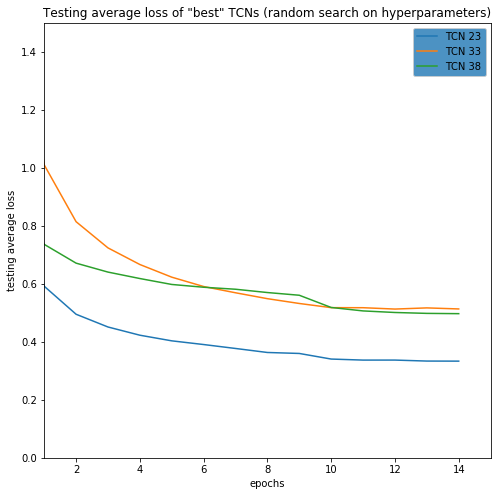

In [303]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
new_new_params = []

for i, score in enumerate(o):
    if score['accuracies'][-1] > .80:
        new_new_params.append(list_params[i])
        ax.plot([sum(i for i, _ in losses)/len(losses) for losses in score['train_losses']], label="TCN {0}".format(new_params[i][1]))

        
legend = ax.legend()
legend.get_frame().set_facecolor('C0')
plt.axis([1, 15, 0, 1.5])
plt.ylabel('testing average loss')
plt.xlabel('epochs')
plt.title('Testing average loss of "best" TCNs (random search on hyperparameters)')
plt.show()

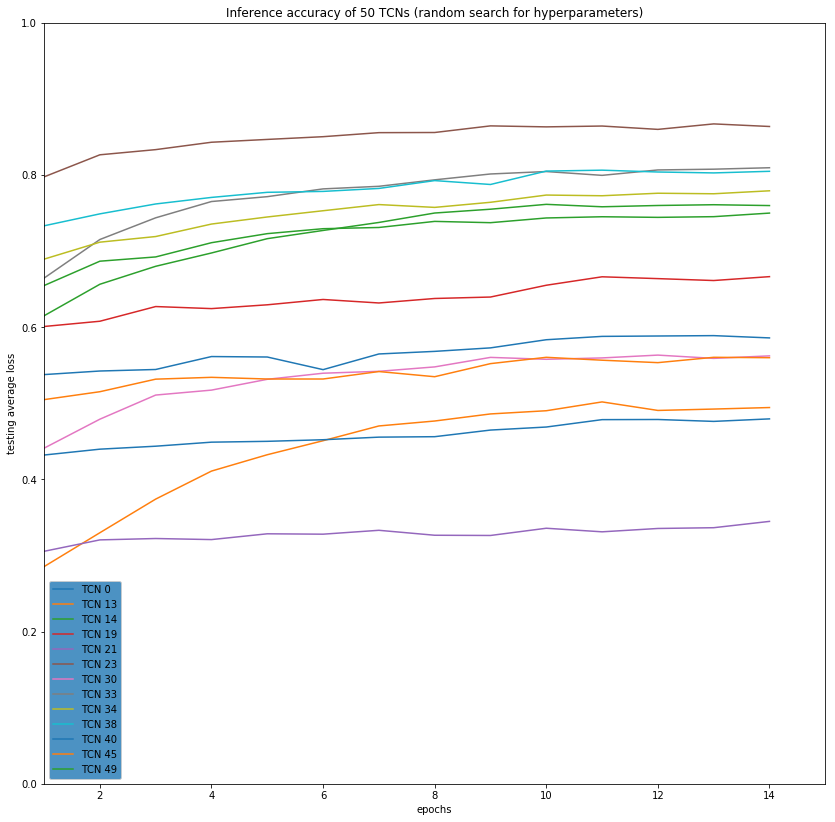

In [304]:
fig, ax = plt.subplots(figsize=(14, 14))

for i, score in enumerate(o):
    ax.plot([s for s in score['accuracies']], label="TCN {0}".format(new_params[i][1]))
        
legend = ax.legend()
legend.get_frame().set_facecolor('C0')
plt.axis([1, 15, 0, 1])
plt.ylabel('testing average loss')
plt.xlabel('epochs')
plt.title('Inference accuracy of 50 TCNs (random search for hyperparameters)')
plt.show()

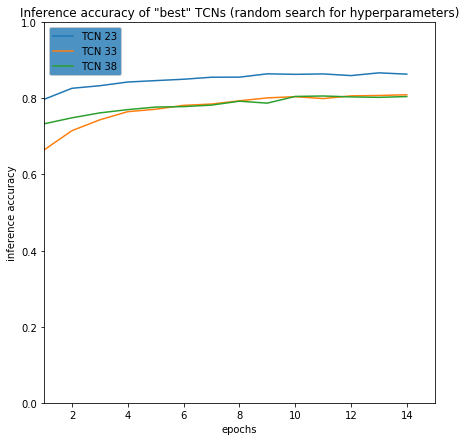

In [305]:
fig, ax = plt.subplots(figsize=(7, 7))

for i, score in enumerate(o):
    if score['accuracies'][-1] > .80:
        ax.plot([s for s in score['accuracies']], label="TCN {0}".format(new_params[i][1]))
        
legend = ax.legend()
legend.get_frame().set_facecolor('C0')
plt.axis([1, 15, 0, 1])
plt.ylabel('inference accuracy')
plt.xlabel('epochs')
plt.title('Inference accuracy of "best" TCNs (random search for hyperparameters)')
plt.show()

In [313]:
for i, score in enumerate(o):
    if score['accuracies'][-1] > 0.80:
        print(i, score['accuracies'][-1])
        print(new_params[i])
# print(new_new_params)

5 0.8637
({'batch_size': 64, 'dropout': 0.15803481115567097, 'clip': 0.47085563508849626, 'lr': 0.0002099003405580982, 'ksize': 6, 'levels': 8, 'optim': 'Adam', 'nhid': 26, 'epochs': 3}, 23)
7 0.8095
({'batch_size': 64, 'dropout': 0.15122917904259725, 'clip': 0.9923886060444691, 'lr': 0.00012157328827402978, 'ksize': 3, 'levels': 8, 'optim': 'Adam', 'nhid': 24, 'epochs': 4}, 33)
9 0.8048
({'batch_size': 32, 'dropout': 0.05659224872343427, 'clip': 0.8612920390429313, 'lr': 0.004275815766747889, 'ksize': 6, 'levels': 5, 'optim': 'Adam', 'nhid': 25, 'epochs': 1}, 38)


In [315]:
import random
num_models = 50
seen_hyper = set()
list_parameters = [{} for i in range(0, num_models)]
for i in range(0, num_models):
    while(True):
        list_parameters[i]['batch_size'] = random.choice([32, 64, 128])
        list_parameters[i]['dropout'] = np.random.uniform(0., 0.60)
        list_parameters[i]['clip'] = np.random.uniform(0.2, 1)
        list_parameters[i]['lr'] = pow(10, np.random.uniform(-6, -2))
        list_parameters[i]['ksize'] = np.random.randint(3, 7)
        list_parameters[i]['levels'] = np.random.randint(5, 9)
        list_parameters[i]['optim'] = 'Adam'
        list_parameters[i]['nhid'] = np.random.randint(20, 30)
        list_parameters[i]['epochs'] = 5
        k = "".join(str(v) + '_' for k, v in list_parameters[i].items())
        if k not in seen_hyper:
            seen_hyper.add(k)
            break
save_obj(list_parameters, 'new_list_parameters')
[param for param in list_parameters]

[{'batch_size': 32,
  'dropout': 0.5867010918637766,
  'clip': 0.8424842254032971,
  'lr': 0.0005321413416390871,
  'ksize': 3,
  'levels': 8,
  'optim': 'Adam',
  'nhid': 22,
  'epochs': 5},
 {'batch_size': 128,
  'dropout': 0.5954237096961861,
  'clip': 0.31934631242852457,
  'lr': 0.00010627592593707352,
  'ksize': 6,
  'levels': 6,
  'optim': 'Adam',
  'nhid': 20,
  'epochs': 5},
 {'batch_size': 128,
  'dropout': 0.3374395737641672,
  'clip': 0.6471912413872007,
  'lr': 0.0012033676497161245,
  'ksize': 6,
  'levels': 5,
  'optim': 'Adam',
  'nhid': 24,
  'epochs': 5},
 {'batch_size': 32,
  'dropout': 0.054427468927671474,
  'clip': 0.8291600263170378,
  'lr': 0.0001914417943740598,
  'ksize': 5,
  'levels': 8,
  'optim': 'Adam',
  'nhid': 24,
  'epochs': 5},
 {'batch_size': 32,
  'dropout': 0.2732913948200143,
  'clip': 0.37714226041960547,
  'lr': 1.6604535938909617e-05,
  'ksize': 3,
  'levels': 6,
  'optim': 'Adam',
  'nhid': 29,
  'epochs': 5},
 {'batch_size': 32,
  'dropout':

In [316]:
# def runListParams(list_parameters):
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_channels = 1 # just one for the image
classes = ('T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
n_classes = len(classes) # 10 classes for fashion-mnist
log_interval = 100
seed = 1111
torch.manual_seed(seed)
permutee = False
input_channels = 1
seq_length = int(784 / input_channels)
steps = 0
cuda = True
scores = []

for model_indx, parameters in enumerate(list_parameters):
    print(parameters)    
#     permute = torch.Tensor(np.random.permutation(784).astype(np.float64)).long()
#     permute = permute.to(device)

    train_loader, test_loader = data_generator('../data/fashion_mnist', parameters['batch_size'])

    model = TCN(input_channels, n_classes, hidden_units=parameters['nhid'], levels=parameters['levels'], kernel_size=parameters['ksize'], dropout=parameters['dropout'])
    model = nn.DataParallel(model)
    model.to(device)
    steps = 0
#     print(count_parameters(model))
    lr = parameters['lr']
    optimizer = getattr(optim, parameters['optim'])(model.parameters(), lr=lr)
    accuracies_ = []
    train_losses_ = [[] for i in range(0, parameters['epochs'])]
    test_losses_ = []
    file_name = './best_models/model_{0}_scnd_tunning.pt'.format(model_indx)

    for epoch in range(1, parameters['epochs']+1):
        trainTCN(epoch)
        test_losses_.append(testTCN())
        if epoch % 5 == 0: 
            print('Saving checkpoint for model.....')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.module.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses_,
                'test_losses': test_losses_,
                'accuracies': accuracies_,
                'curr_lr': lr,
            }, file_name)
        if epoch % 10 == 0:
            lr /= 10
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
    torch.save(model.module.state_dict(), file_name)
    scores.append({
        'accuracies': accuracies_,
        'train_losses': train_losses_,
        'test_losses': test_losses_,
    })
    print('Saved as %s' % file_name) 
save_obj(scores, './best_models/scores_1')

{'batch_size': 32, 'dropout': 0.5867010918637766, 'clip': 0.8424842254032971, 'lr': 0.0005321413416390871, 'ksize': 3, 'levels': 8, 'optim': 'Adam', 'nhid': 22, 'epochs': 5}
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.382290	Steps: 79184
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.288536	Steps: 157584
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.241023	Steps: 235984
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.150758	Steps: 314384
Train Epoch: 1 [16000/60000 (27%)]	Loss: 2.081146	Steps: 392784
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.997055	Steps: 471184
Train Epoch: 1 [22400/60000 (37%)]	Loss: 1.921772	Steps: 549584
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.842911	Steps: 627984
Train Epoch: 1 [28800/60000 (48%)]	Loss: 1.793515	Steps: 706384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.747071	Steps: 784784
Train Epoch: 1 [35200/60000 (59%)]	Loss: 1.711622	Steps: 863184
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.645855	Steps: 941584
Train Epoch: 1 [41600/60000 (69%)]	Loss: 1.625848	Steps: 101998

Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.799997	Steps: 549584
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.753242	Steps: 627984
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.743052	Steps: 706384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.693879	Steps: 784784
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.668720	Steps: 863184
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.653320	Steps: 941584
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.624935	Steps: 1019984
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.623072	Steps: 1098384
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.607106	Steps: 1176784
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.586343	Steps: 1255184
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.593537	Steps: 1333584
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.549863	Steps: 1411984

Test set: Average loss: 0.6251, Accuracy: 7811/10000 (78%)

Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.551269	Steps: 1549184
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.526149	Steps: 1627584
Train Epoch: 2 [9600/60000 (16%)]	Loss

Train Epoch: 2 [54400/60000 (91%)]	Loss: 1.934532	Steps: 2803584
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.940208	Steps: 2881984

Test set: Average loss: 1.9178, Accuracy: 2563/10000 (25%)

Train Epoch: 3 [3200/60000 (5%)]	Loss: 1.935092	Steps: 3019184
Train Epoch: 3 [6400/60000 (11%)]	Loss: 1.913032	Steps: 3097584
Train Epoch: 3 [9600/60000 (16%)]	Loss: 1.896587	Steps: 3175984
Train Epoch: 3 [12800/60000 (21%)]	Loss: 1.885760	Steps: 3254384
Train Epoch: 3 [16000/60000 (27%)]	Loss: 1.872130	Steps: 3332784
Train Epoch: 3 [19200/60000 (32%)]	Loss: 1.842298	Steps: 3411184
Train Epoch: 3 [22400/60000 (37%)]	Loss: 1.830322	Steps: 3489584
Train Epoch: 3 [25600/60000 (43%)]	Loss: 1.841658	Steps: 3567984
Train Epoch: 3 [28800/60000 (48%)]	Loss: 1.840880	Steps: 3646384
Train Epoch: 3 [32000/60000 (53%)]	Loss: 1.823304	Steps: 3724784
Train Epoch: 3 [35200/60000 (59%)]	Loss: 1.807937	Steps: 3803184
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.798757	Steps: 3881584
Train Epoch: 3 [41600/60000 (69%)

Train Epoch: 4 [25600/60000 (43%)]	Loss: 1.658788	Steps: 5037984
Train Epoch: 4 [28800/60000 (48%)]	Loss: 1.661569	Steps: 5116384
Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.642158	Steps: 5194784
Train Epoch: 4 [35200/60000 (59%)]	Loss: 1.622428	Steps: 5273184
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.618274	Steps: 5351584
Train Epoch: 4 [41600/60000 (69%)]	Loss: 1.592016	Steps: 5429984
Train Epoch: 4 [44800/60000 (75%)]	Loss: 1.624960	Steps: 5508384
Train Epoch: 4 [48000/60000 (80%)]	Loss: 1.626803	Steps: 5586784
Train Epoch: 4 [51200/60000 (85%)]	Loss: 1.588490	Steps: 5665184
Train Epoch: 4 [54400/60000 (91%)]	Loss: 1.572664	Steps: 5743584
Train Epoch: 4 [57600/60000 (96%)]	Loss: 1.580809	Steps: 5821984

Test set: Average loss: 1.5827, Accuracy: 3736/10000 (37%)

Train Epoch: 5 [3200/60000 (5%)]	Loss: 1.591374	Steps: 5959184
Train Epoch: 5 [6400/60000 (11%)]	Loss: 1.572354	Steps: 6037584
Train Epoch: 5 [9600/60000 (16%)]	Loss: 1.594943	Steps: 6115984
Train Epoch: 5 [12800/60000 (21%)

Train Epoch: 4 [25600/60000 (43%)]	Loss: 2.105169	Steps: 5037984
Train Epoch: 4 [28800/60000 (48%)]	Loss: 2.095493	Steps: 5116384
Train Epoch: 4 [32000/60000 (53%)]	Loss: 2.083490	Steps: 5194784
Train Epoch: 4 [35200/60000 (59%)]	Loss: 2.080431	Steps: 5273184
Train Epoch: 4 [38400/60000 (64%)]	Loss: 2.069633	Steps: 5351584
Train Epoch: 4 [41600/60000 (69%)]	Loss: 2.061191	Steps: 5429984
Train Epoch: 4 [44800/60000 (75%)]	Loss: 2.060294	Steps: 5508384
Train Epoch: 4 [48000/60000 (80%)]	Loss: 2.052344	Steps: 5586784
Train Epoch: 4 [51200/60000 (85%)]	Loss: 2.032857	Steps: 5665184
Train Epoch: 4 [54400/60000 (91%)]	Loss: 2.020272	Steps: 5743584
Train Epoch: 4 [57600/60000 (96%)]	Loss: 2.017479	Steps: 5821984

Test set: Average loss: 2.0004, Accuracy: 3239/10000 (32%)

Train Epoch: 5 [3200/60000 (5%)]	Loss: 2.019409	Steps: 5959184
Train Epoch: 5 [6400/60000 (11%)]	Loss: 1.998470	Steps: 6037584
Train Epoch: 5 [9600/60000 (16%)]	Loss: 1.991147	Steps: 6115984
Train Epoch: 5 [12800/60000 (21%)

Train Epoch: 5 [57600/60000 (96%)]	Loss: 1.132492	Steps: 7291984

Test set: Average loss: 1.1433, Accuracy: 5437/10000 (54%)

Saving checkpoint for model.....
Saved as ./best_models/model_8_scnd_tunning.pt
{'batch_size': 128, 'dropout': 0.29048829641411367, 'clip': 0.5625984508966597, 'lr': 0.0018362548306745871, 'ksize': 3, 'levels': 8, 'optim': 'Adam', 'nhid': 21, 'epochs': 5}
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.916957	Steps: 79184
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.167602	Steps: 157584
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.960480	Steps: 235984
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.871707	Steps: 314384

Test set: Average loss: 0.8319, Accuracy: 6882/10000 (68%)

Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.781793	Steps: 446880
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.770939	Steps: 525280
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.732396	Steps: 603680
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.703813	Steps: 682080

Test set: Average loss: 0.7068, Accuracy: 737

Train Epoch: 3 [6400/60000 (11%)]	Loss: 2.192983	Steps: 3097584
Train Epoch: 3 [9600/60000 (16%)]	Loss: 2.184980	Steps: 3175984
Train Epoch: 3 [12800/60000 (21%)]	Loss: 2.180721	Steps: 3254384
Train Epoch: 3 [16000/60000 (27%)]	Loss: 2.169977	Steps: 3332784
Train Epoch: 3 [19200/60000 (32%)]	Loss: 2.163253	Steps: 3411184
Train Epoch: 3 [22400/60000 (37%)]	Loss: 2.147335	Steps: 3489584
Train Epoch: 3 [25600/60000 (43%)]	Loss: 2.148815	Steps: 3567984
Train Epoch: 3 [28800/60000 (48%)]	Loss: 2.143424	Steps: 3646384
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.126527	Steps: 3724784
Train Epoch: 3 [35200/60000 (59%)]	Loss: 2.130973	Steps: 3803184
Train Epoch: 3 [38400/60000 (64%)]	Loss: 2.115849	Steps: 3881584
Train Epoch: 3 [41600/60000 (69%)]	Loss: 2.125970	Steps: 3959984
Train Epoch: 3 [44800/60000 (75%)]	Loss: 2.096338	Steps: 4038384
Train Epoch: 3 [48000/60000 (80%)]	Loss: 2.081849	Steps: 4116784
Train Epoch: 3 [51200/60000 (85%)]	Loss: 2.083477	Steps: 4195184
Train Epoch: 3 [54400/60000

Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.915599	Steps: 814576
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.881989	Steps: 892976
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.889172	Steps: 971376
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.881357	Steps: 1049776

Test set: Average loss: 0.8853, Accuracy: 6582/10000 (65%)

Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.875592	Steps: 1182272
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.859738	Steps: 1260672
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.854372	Steps: 1339072
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.855068	Steps: 1417472

Test set: Average loss: 0.8353, Accuracy: 6758/10000 (67%)

Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.843690	Steps: 1549968
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.839921	Steps: 1628368
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.837506	Steps: 1706768
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.825662	Steps: 1785168

Test set: Average loss: 0.8391, Accuracy: 6790/10000 (67%)

Saving checkpoint for model.....
Saved a

Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.336503	Steps: 2097984
Train Epoch: 2 [28800/60000 (48%)]	Loss: 2.329604	Steps: 2176384
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.331805	Steps: 2254784
Train Epoch: 2 [35200/60000 (59%)]	Loss: 2.333949	Steps: 2333184
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.336550	Steps: 2411584
Train Epoch: 2 [41600/60000 (69%)]	Loss: 2.327869	Steps: 2489984
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.331158	Steps: 2568384
Train Epoch: 2 [48000/60000 (80%)]	Loss: 2.326839	Steps: 2646784
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.319338	Steps: 2725184
Train Epoch: 2 [54400/60000 (91%)]	Loss: 2.335726	Steps: 2803584
Train Epoch: 2 [57600/60000 (96%)]	Loss: 2.327504	Steps: 2881984

Test set: Average loss: 2.3263, Accuracy: 1011/10000 (10%)

Train Epoch: 3 [3200/60000 (5%)]	Loss: 2.350932	Steps: 3019184
Train Epoch: 3 [6400/60000 (11%)]	Loss: 2.324741	Steps: 3097584
Train Epoch: 3 [9600/60000 (16%)]	Loss: 2.324085	Steps: 3175984
Train Epoch: 3 [12800/60000 (21%)

Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.229397	Steps: 157584
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.117970	Steps: 235984
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.056170	Steps: 314384

Test set: Average loss: 1.0024, Accuracy: 6039/10000 (60%)

Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.002767	Steps: 446880
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.969792	Steps: 525280
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.955424	Steps: 603680
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.936357	Steps: 682080

Test set: Average loss: 0.9244, Accuracy: 6327/10000 (63%)

Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.920565	Steps: 814576
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.915031	Steps: 892976
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.900171	Steps: 971376
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.895551	Steps: 1049776

Test set: Average loss: 0.8773, Accuracy: 6466/10000 (64%)

Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.882918	Steps: 1182272
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.8689

Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.490414	Steps: 157584
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.446875	Steps: 235984
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.426795	Steps: 314384
Train Epoch: 1 [16000/60000 (27%)]	Loss: 2.418283	Steps: 392784
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.406000	Steps: 471184
Train Epoch: 1 [22400/60000 (37%)]	Loss: 2.396374	Steps: 549584
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.400806	Steps: 627984
Train Epoch: 1 [28800/60000 (48%)]	Loss: 2.380811	Steps: 706384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.378200	Steps: 784784
Train Epoch: 1 [35200/60000 (59%)]	Loss: 2.363273	Steps: 863184
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.359896	Steps: 941584
Train Epoch: 1 [41600/60000 (69%)]	Loss: 2.368020	Steps: 1019984
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.355499	Steps: 1098384
Train Epoch: 1 [48000/60000 (80%)]	Loss: 2.353801	Steps: 1176784
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.350073	Steps: 1255184
Train Epoch: 1 [54400/60000 (91%)]	Los

Train Epoch: 4 [6400/60000 (11%)]	Loss: 1.759643	Steps: 2285360
Train Epoch: 4 [12800/60000 (21%)]	Loss: 1.727779	Steps: 2363760
Train Epoch: 4 [19200/60000 (32%)]	Loss: 1.709005	Steps: 2442160
Train Epoch: 4 [25600/60000 (43%)]	Loss: 1.680419	Steps: 2520560
Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.682720	Steps: 2598960
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.648310	Steps: 2677360
Train Epoch: 4 [44800/60000 (75%)]	Loss: 1.630005	Steps: 2755760
Train Epoch: 4 [51200/60000 (85%)]	Loss: 1.601743	Steps: 2834160
Train Epoch: 4 [57600/60000 (96%)]	Loss: 1.592526	Steps: 2912560

Test set: Average loss: 1.5857, Accuracy: 3957/10000 (39%)

Train Epoch: 5 [6400/60000 (11%)]	Loss: 1.593842	Steps: 3020752
Train Epoch: 5 [12800/60000 (21%)]	Loss: 1.568066	Steps: 3099152
Train Epoch: 5 [19200/60000 (32%)]	Loss: 1.564954	Steps: 3177552
Train Epoch: 5 [25600/60000 (43%)]	Loss: 1.548270	Steps: 3255952
Train Epoch: 5 [32000/60000 (53%)]	Loss: 1.538910	Steps: 3334352
Train Epoch: 5 [38400/60000 (64

Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.667884	Steps: 471184
Train Epoch: 1 [22400/60000 (37%)]	Loss: 1.561377	Steps: 549584
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.468851	Steps: 627984
Train Epoch: 1 [28800/60000 (48%)]	Loss: 1.404614	Steps: 706384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.326922	Steps: 784784
Train Epoch: 1 [35200/60000 (59%)]	Loss: 1.258225	Steps: 863184
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.221792	Steps: 941584
Train Epoch: 1 [41600/60000 (69%)]	Loss: 1.161918	Steps: 1019984
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.124596	Steps: 1098384
Train Epoch: 1 [48000/60000 (80%)]	Loss: 1.117552	Steps: 1176784
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.039349	Steps: 1255184
Train Epoch: 1 [54400/60000 (91%)]	Loss: 1.044431	Steps: 1333584
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.009072	Steps: 1411984

Test set: Average loss: 0.9766, Accuracy: 6378/10000 (63%)

Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.963067	Steps: 1549184
Train Epoch: 2 [6400/60000 (11%)]	Loss

Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.669865	Steps: 2598960
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.644361	Steps: 2677360
Train Epoch: 4 [44800/60000 (75%)]	Loss: 1.630907	Steps: 2755760
Train Epoch: 4 [51200/60000 (85%)]	Loss: 1.608359	Steps: 2834160
Train Epoch: 4 [57600/60000 (96%)]	Loss: 1.590560	Steps: 2912560

Test set: Average loss: 1.5809, Accuracy: 4092/10000 (40%)

Train Epoch: 5 [6400/60000 (11%)]	Loss: 1.594252	Steps: 3020752
Train Epoch: 5 [12800/60000 (21%)]	Loss: 1.578936	Steps: 3099152
Train Epoch: 5 [19200/60000 (32%)]	Loss: 1.562932	Steps: 3177552
Train Epoch: 5 [25600/60000 (43%)]	Loss: 1.543440	Steps: 3255952
Train Epoch: 5 [32000/60000 (53%)]	Loss: 1.552308	Steps: 3334352
Train Epoch: 5 [38400/60000 (64%)]	Loss: 1.522792	Steps: 3412752
Train Epoch: 5 [44800/60000 (75%)]	Loss: 1.522258	Steps: 3491152
Train Epoch: 5 [51200/60000 (85%)]	Loss: 1.516332	Steps: 3569552
Train Epoch: 5 [57600/60000 (96%)]	Loss: 1.495649	Steps: 3647952

Test set: Average loss: 1.495

Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.722672	Steps: 1941968
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.743640	Steps: 2020368
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.734727	Steps: 2098768
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.732778	Steps: 2177168

Test set: Average loss: 0.7231, Accuracy: 7227/10000 (72%)

Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.714677	Steps: 2285360
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.710226	Steps: 2363760
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.720358	Steps: 2442160
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.693539	Steps: 2520560
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.708077	Steps: 2598960
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.691786	Steps: 2677360
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.695219	Steps: 2755760
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.674868	Steps: 2834160
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.700664	Steps: 2912560

Test set: Average loss: 0.6922, Accuracy: 7410/10000 (74%)

Train Epoch: 5 [6400/60000 (11%)]	

Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.317824	Steps: 79184
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.082404	Steps: 157584
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.743999	Steps: 235984
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.470571	Steps: 314384

Test set: Average loss: 1.2748, Accuracy: 5354/10000 (53%)

Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.249908	Steps: 446880
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.148510	Steps: 525280
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.085582	Steps: 603680
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.032538	Steps: 682080

Test set: Average loss: 0.9897, Accuracy: 6325/10000 (63%)

Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.971533	Steps: 814576
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.942766	Steps: 892976
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.906438	Steps: 971376
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.877609	Steps: 1049776

Test set: Average loss: 0.8820, Accuracy: 6769/10000 (67%)

Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.859256

Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.368796	Steps: 79184
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.303371	Steps: 157584
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.257142	Steps: 235984
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.179758	Steps: 314384
Train Epoch: 1 [16000/60000 (27%)]	Loss: 2.091209	Steps: 392784
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.987597	Steps: 471184
Train Epoch: 1 [22400/60000 (37%)]	Loss: 1.906186	Steps: 549584
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.831808	Steps: 627984
Train Epoch: 1 [28800/60000 (48%)]	Loss: 1.781812	Steps: 706384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.721685	Steps: 784784
Train Epoch: 1 [35200/60000 (59%)]	Loss: 1.666255	Steps: 863184
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.643379	Steps: 941584
Train Epoch: 1 [41600/60000 (69%)]	Loss: 1.590312	Steps: 1019984
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.595185	Steps: 1098384
Train Epoch: 1 [48000/60000 (80%)]	Loss: 1.565162	Steps: 1176784
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1

Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.107586	Steps: 79184
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.430072	Steps: 157584
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.256286	Steps: 235984
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.142498	Steps: 314384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.084485	Steps: 392784
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.993764	Steps: 471184
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.990982	Steps: 549584
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.960088	Steps: 627984
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.933930	Steps: 706384

Test set: Average loss: 0.9182, Accuracy: 6496/10000 (64%)

Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.908825	Steps: 814576
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.880150	Steps: 892976
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.895613	Steps: 971376
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.838942	Steps: 1049776
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.855060	Steps: 1128176
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.8

Train Epoch: 3 [25600/60000 (43%)]	Loss: 1.187844	Steps: 3567984
Train Epoch: 3 [28800/60000 (48%)]	Loss: 1.198225	Steps: 3646384
Train Epoch: 3 [32000/60000 (53%)]	Loss: 1.168650	Steps: 3724784
Train Epoch: 3 [35200/60000 (59%)]	Loss: 1.151973	Steps: 3803184
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.121724	Steps: 3881584
Train Epoch: 3 [41600/60000 (69%)]	Loss: 1.135862	Steps: 3959984
Train Epoch: 3 [44800/60000 (75%)]	Loss: 1.138151	Steps: 4038384
Train Epoch: 3 [48000/60000 (80%)]	Loss: 1.141951	Steps: 4116784
Train Epoch: 3 [51200/60000 (85%)]	Loss: 1.097304	Steps: 4195184
Train Epoch: 3 [54400/60000 (91%)]	Loss: 1.116569	Steps: 4273584
Train Epoch: 3 [57600/60000 (96%)]	Loss: 1.098198	Steps: 4351984

Test set: Average loss: 1.0959, Accuracy: 5887/10000 (58%)

Train Epoch: 4 [3200/60000 (5%)]	Loss: 1.093728	Steps: 4489184
Train Epoch: 4 [6400/60000 (11%)]	Loss: 1.047889	Steps: 4567584
Train Epoch: 4 [9600/60000 (16%)]	Loss: 1.080544	Steps: 4645984
Train Epoch: 4 [12800/60000 (21%)

Train Epoch: 4 [57600/60000 (96%)]	Loss: 2.286137	Steps: 5821984

Test set: Average loss: 2.2845, Accuracy: 1394/10000 (13%)

Train Epoch: 5 [3200/60000 (5%)]	Loss: 2.307439	Steps: 5959184
Train Epoch: 5 [6400/60000 (11%)]	Loss: 2.283117	Steps: 6037584
Train Epoch: 5 [9600/60000 (16%)]	Loss: 2.287186	Steps: 6115984
Train Epoch: 5 [12800/60000 (21%)]	Loss: 2.277742	Steps: 6194384
Train Epoch: 5 [16000/60000 (27%)]	Loss: 2.284670	Steps: 6272784
Train Epoch: 5 [19200/60000 (32%)]	Loss: 2.281160	Steps: 6351184
Train Epoch: 5 [22400/60000 (37%)]	Loss: 2.277596	Steps: 6429584
Train Epoch: 5 [25600/60000 (43%)]	Loss: 2.278955	Steps: 6507984
Train Epoch: 5 [28800/60000 (48%)]	Loss: 2.279942	Steps: 6586384
Train Epoch: 5 [32000/60000 (53%)]	Loss: 2.277377	Steps: 6664784
Train Epoch: 5 [35200/60000 (59%)]	Loss: 2.277824	Steps: 6743184
Train Epoch: 5 [38400/60000 (64%)]	Loss: 2.278712	Steps: 6821584
Train Epoch: 5 [41600/60000 (69%)]	Loss: 2.275186	Steps: 6899984
Train Epoch: 5 [44800/60000 (75%)

Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.504742	Steps: 3881584
Train Epoch: 3 [41600/60000 (69%)]	Loss: 1.487625	Steps: 3959984
Train Epoch: 3 [44800/60000 (75%)]	Loss: 1.459618	Steps: 4038384
Train Epoch: 3 [48000/60000 (80%)]	Loss: 1.454679	Steps: 4116784
Train Epoch: 3 [51200/60000 (85%)]	Loss: 1.411170	Steps: 4195184
Train Epoch: 3 [54400/60000 (91%)]	Loss: 1.402660	Steps: 4273584
Train Epoch: 3 [57600/60000 (96%)]	Loss: 1.364436	Steps: 4351984

Test set: Average loss: 1.3501, Accuracy: 5675/10000 (56%)

Train Epoch: 4 [3200/60000 (5%)]	Loss: 1.347677	Steps: 4489184
Train Epoch: 4 [6400/60000 (11%)]	Loss: 1.299130	Steps: 4567584
Train Epoch: 4 [9600/60000 (16%)]	Loss: 1.294721	Steps: 4645984
Train Epoch: 4 [12800/60000 (21%)]	Loss: 1.291356	Steps: 4724384
Train Epoch: 4 [16000/60000 (27%)]	Loss: 1.277035	Steps: 4802784
Train Epoch: 4 [19200/60000 (32%)]	Loss: 1.283389	Steps: 4881184
Train Epoch: 4 [22400/60000 (37%)]	Loss: 1.245600	Steps: 4959584
Train Epoch: 4 [25600/60000 (43%)

Train Epoch: 5 [9600/60000 (16%)]	Loss: 2.001809	Steps: 6115984
Train Epoch: 5 [12800/60000 (21%)]	Loss: 1.998731	Steps: 6194384
Train Epoch: 5 [16000/60000 (27%)]	Loss: 1.998347	Steps: 6272784
Train Epoch: 5 [19200/60000 (32%)]	Loss: 2.002774	Steps: 6351184
Train Epoch: 5 [22400/60000 (37%)]	Loss: 1.977526	Steps: 6429584
Train Epoch: 5 [25600/60000 (43%)]	Loss: 1.966895	Steps: 6507984
Train Epoch: 5 [28800/60000 (48%)]	Loss: 1.971202	Steps: 6586384
Train Epoch: 5 [32000/60000 (53%)]	Loss: 1.948648	Steps: 6664784
Train Epoch: 5 [35200/60000 (59%)]	Loss: 1.945277	Steps: 6743184
Train Epoch: 5 [38400/60000 (64%)]	Loss: 1.938466	Steps: 6821584
Train Epoch: 5 [41600/60000 (69%)]	Loss: 1.934780	Steps: 6899984
Train Epoch: 5 [44800/60000 (75%)]	Loss: 1.923235	Steps: 6978384
Train Epoch: 5 [48000/60000 (80%)]	Loss: 1.912124	Steps: 7056784
Train Epoch: 5 [51200/60000 (85%)]	Loss: 1.896414	Steps: 7135184
Train Epoch: 5 [54400/60000 (91%)]	Loss: 1.885925	Steps: 7213584
Train Epoch: 5 [57600/6000

Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.974730	Steps: 1941184
Train Epoch: 2 [22400/60000 (37%)]	Loss: 0.961344	Steps: 2019584
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.948634	Steps: 2097984
Train Epoch: 2 [28800/60000 (48%)]	Loss: 0.931722	Steps: 2176384
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.921816	Steps: 2254784
Train Epoch: 2 [35200/60000 (59%)]	Loss: 0.899320	Steps: 2333184
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.879274	Steps: 2411584
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.868433	Steps: 2489984
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.885515	Steps: 2568384
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.872697	Steps: 2646784
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.813116	Steps: 2725184
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.867148	Steps: 2803584
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.814741	Steps: 2881984

Test set: Average loss: 0.8470, Accuracy: 6741/10000 (67%)

Train Epoch: 3 [3200/60000 (5%)]	Loss: 0.865379	Steps: 3019184
Train Epoch: 3 [6400/60000 (11%

Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.319020	Steps: 1863568
Train Epoch: 3 [38400/60000 (64%)]	Loss: 2.312938	Steps: 1941968
Train Epoch: 3 [44800/60000 (75%)]	Loss: 2.318471	Steps: 2020368
Train Epoch: 3 [51200/60000 (85%)]	Loss: 2.315795	Steps: 2098768
Train Epoch: 3 [57600/60000 (96%)]	Loss: 2.314831	Steps: 2177168

Test set: Average loss: 2.3133, Accuracy: 1130/10000 (11%)

Train Epoch: 4 [6400/60000 (11%)]	Loss: 2.340260	Steps: 2285360
Train Epoch: 4 [12800/60000 (21%)]	Loss: 2.310800	Steps: 2363760
Train Epoch: 4 [19200/60000 (32%)]	Loss: 2.308148	Steps: 2442160
Train Epoch: 4 [25600/60000 (43%)]	Loss: 2.312887	Steps: 2520560
Train Epoch: 4 [32000/60000 (53%)]	Loss: 2.307453	Steps: 2598960
Train Epoch: 4 [38400/60000 (64%)]	Loss: 2.303869	Steps: 2677360
Train Epoch: 4 [44800/60000 (75%)]	Loss: 2.307803	Steps: 2755760
Train Epoch: 4 [51200/60000 (85%)]	Loss: 2.306554	Steps: 2834160
Train Epoch: 4 [57600/60000 (96%)]	Loss: 2.305286	Steps: 2912560

Test set: Average loss: 2.303

Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.161767	Steps: 79184
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.481442	Steps: 157584
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.262202	Steps: 235984
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.156876	Steps: 314384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.095092	Steps: 392784
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.032340	Steps: 471184
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.992099	Steps: 549584
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.981980	Steps: 627984
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.945777	Steps: 706384

Test set: Average loss: 0.9566, Accuracy: 6407/10000 (64%)

Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.935508	Steps: 814576
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.914311	Steps: 892976
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.899591	Steps: 971376
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.874530	Steps: 1049776
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.885430	Steps: 1128176
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.8

Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.935490	Steps: 3567984
Train Epoch: 3 [28800/60000 (48%)]	Loss: 0.928594	Steps: 3646384
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.938325	Steps: 3724784
Train Epoch: 3 [35200/60000 (59%)]	Loss: 0.899347	Steps: 3803184
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.941463	Steps: 3881584
Train Epoch: 3 [41600/60000 (69%)]	Loss: 0.909487	Steps: 3959984
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.922094	Steps: 4038384
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.920473	Steps: 4116784
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.902786	Steps: 4195184
Train Epoch: 3 [54400/60000 (91%)]	Loss: 0.904207	Steps: 4273584
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.904456	Steps: 4351984

Test set: Average loss: 0.8882, Accuracy: 6612/10000 (66%)

Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.899482	Steps: 4489184
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.876505	Steps: 4567584
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.929476	Steps: 4645984
Train Epoch: 4 [12800/60000 (21%)

In [23]:
scores = load_obj('./best_models/scores_1')
list_params = load_obj('new_list_parameters')
for i, score in enumerate(scores):
    if score['accuracies'][-1] > .70:
#         print(list_params[i])
        print("Model {0}".format(i))
        print("Parameters => {0}".format(list_params[i]))
        print("Inference accuracy => {0}".format(score['accuracies'][-1]))
        print("Train losses => {0}".format([losses[0][0] for losses in score['train_losses']]))
        print("Test losses => {0}".format([losses for losses in score['test_losses']]))    


Model 3
Parameters => {'batch_size': 32, 'dropout': 0.054427468927671474, 'clip': 0.8291600263170378, 'lr': 0.0001914417943740598, 'ksize': 5, 'levels': 8, 'optim': 'Adam', 'nhid': 24, 'epochs': 5}
Inference accuracy => 0.8601
Train losses => [2.2248787903785705, 0.5512693870067596, 0.44567800223827364, 0.39952474132180216, 0.3669141112267971]
Test losses => [0.625066830444336, 0.4917054522037506, 0.43219972085952757, 0.403313695025444, 0.39142868957519533]
Model 9
Parameters => {'batch_size': 128, 'dropout': 0.29048829641411367, 'clip': 0.5625984508966597, 'lr': 0.0018362548306745871, 'ksize': 3, 'levels': 8, 'optim': 'Adam', 'nhid': 21, 'epochs': 5}
Inference accuracy => 0.7696
Train losses => [1.916957013607025, 0.7817932540178298, 0.6855662131309509, 0.6364443409442901, 0.6069987481832504]
Test losses => [0.8319235608100891, 0.7068275526046753, 0.6568296066284179, 0.6206888483524322, 0.6193477052688598]
Model 13
Parameters => {'batch_size': 128, 'dropout': 0.12466549806419837, 'cli

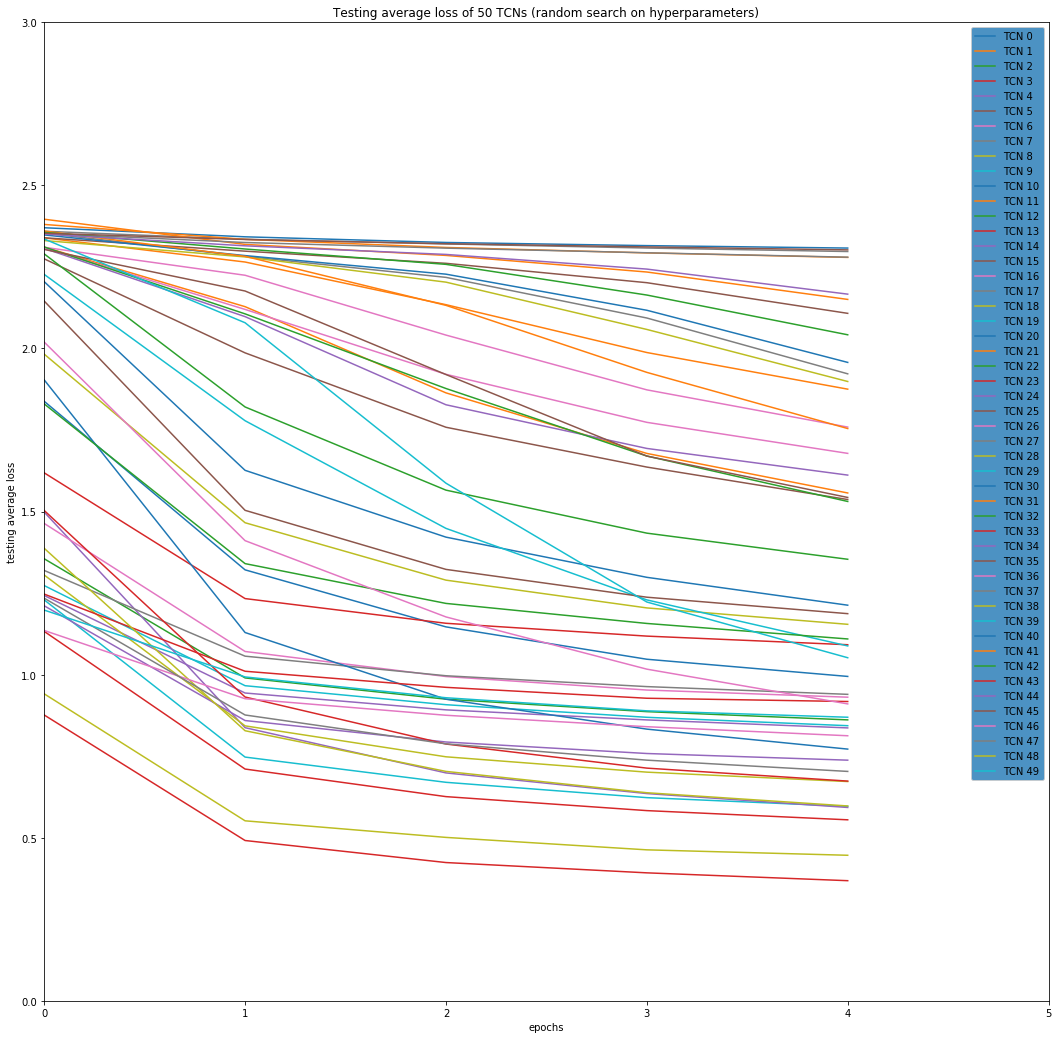

In [24]:
plotTrainLosses(scores, fsize=18, xlabel='epochs', ylabel='testing average loss', 
                title='Testing average loss of 50 TCNs (random search on hyperparameters)')


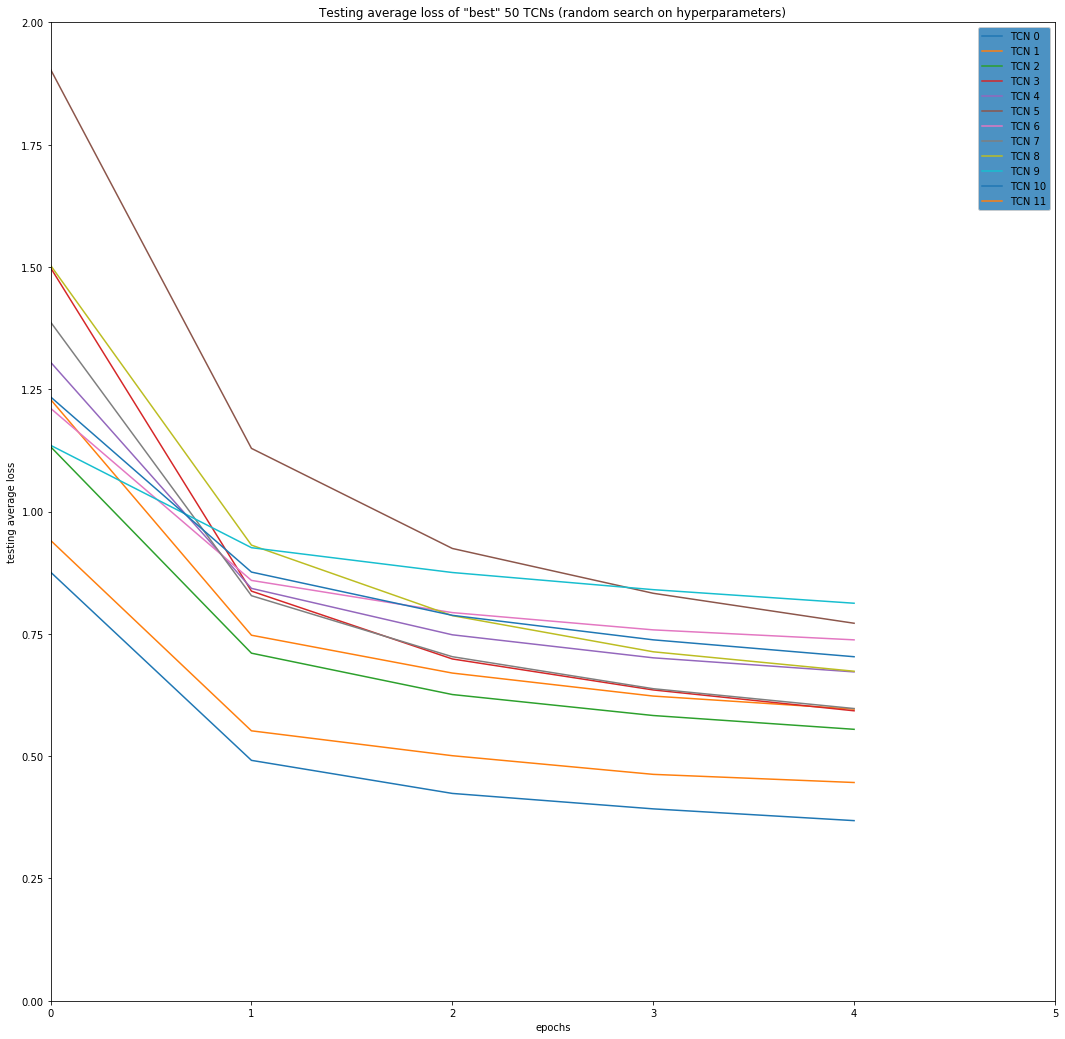

In [25]:
plotTrainLosses([s for s in scores if s['accuracies'][-1] >= 0.70], fsize=18, xlabel='epochs', ylabel='testing average loss', 
                title='Testing average loss of "best" 50 TCNs (random search on hyperparameters)',
               axis=[0, 5, 0, 2])


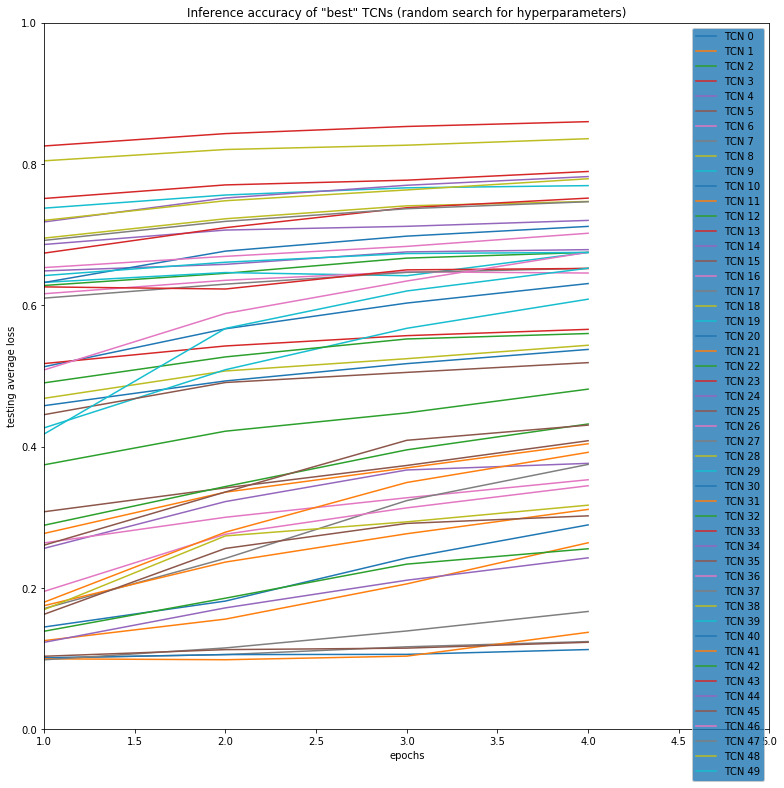

In [26]:
plotAccuracies(scores, fsize=13, acc_score=0., xlabel='epochs', 
               ylabel='testing average loss', axis=[1, 5, 0, 1],
                title='Inference accuracy of "best" TCNs (random search for hyperparameters)')

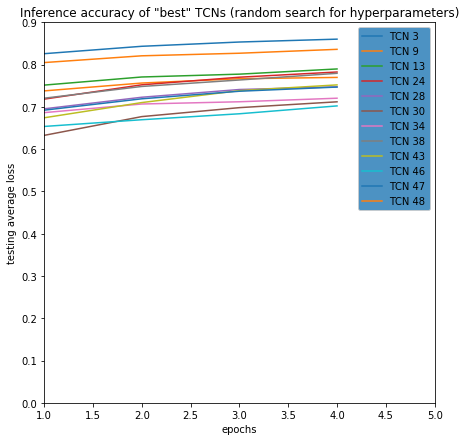

In [27]:
plotAccuracies(scores, fsize=7, acc_score=0.7, xlabel='epochs', 
               ylabel='testing average loss', axis=[1, 5, 0, 0.9],
                title='Inference accuracy of "best" TCNs (random search for hyperparameters)')

In [28]:
best_score = -1
best_i = -1
for i, score in enumerate(scores):
    if score['accuracies'][-1] > best_score:
        best_score = score['accuracies'][-1]
        best_i = i
print(best_score)
best_i
list_params[best_i]

0.8601


{'batch_size': 32,
 'dropout': 0.054427468927671474,
 'clip': 0.8291600263170378,
 'lr': 0.0001914417943740598,
 'ksize': 5,
 'levels': 8,
 'optim': 'Adam',
 'nhid': 24,
 'epochs': 5}

In [14]:
new_list_params = []
for i, score in enumerate(scores):
    if score['accuracies'][-1] > .70:
        new_list_params.append((list_params[i], i))
new_list_params

[({'batch_size': 32,
   'dropout': 0.054427468927671474,
   'clip': 0.8291600263170378,
   'lr': 0.0001914417943740598,
   'ksize': 5,
   'levels': 8,
   'optim': 'Adam',
   'nhid': 24,
   'epochs': 5},
  3),
 ({'batch_size': 128,
   'dropout': 0.29048829641411367,
   'clip': 0.5625984508966597,
   'lr': 0.0018362548306745871,
   'ksize': 3,
   'levels': 8,
   'optim': 'Adam',
   'nhid': 21,
   'epochs': 5},
  9),
 ({'batch_size': 128,
   'dropout': 0.12466549806419837,
   'clip': 0.8429374035323576,
   'lr': 0.0008805336423915327,
   'ksize': 5,
   'levels': 6,
   'optim': 'Adam',
   'nhid': 27,
   'epochs': 5},
  13),
 ({'batch_size': 32,
   'dropout': 0.21961770142550557,
   'clip': 0.7036194800786204,
   'lr': 6.0682595304921534e-05,
   'ksize': 6,
   'levels': 7,
   'optim': 'Adam',
   'nhid': 28,
   'epochs': 5},
  24),
 ({'batch_size': 64,
   'dropout': 0.44103364548170304,
   'clip': 0.3014576976251056,
   'lr': 0.0012018098639804324,
   'ksize': 3,
   'levels': 8,
   'optim': 

### Test again

In [424]:
# def runListParams(list_parameters):
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_channels = 1 # just one for the image
classes = ('T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
n_classes = len(classes) # 10 classes for fashion-mnist
log_interval = 100
seed = 1111
torch.manual_seed(seed)
permutee = False
input_channels = 1
seq_length = int(784 / input_channels)
steps = 0
cuda = True
scores = []
epochs = 15

for model_indx, parameters in enumerate(new_list_params):
    print(parameters)
#     permute = torch.Tensor(np.random.permutation(784).astype(np.float64)).long()
#     permute = permute.to(device)

    train_loader, test_loader = data_generator('../data/fashion_mnist', parameters[0]['batch_size'])

    model = TCN(input_channels, n_classes, hidden_units=parameters[0]['nhid'], levels=parameters[0]['levels'], kernel_size=parameters[0]['ksize'], dropout=parameters[0]['dropout'])
    model = nn.DataParallel(model)
    model.to(device)
    steps = 0
    print("size of model => {0}".format(count_parameters(model)))
    lr = parameters[0]['lr']
    optimizer = getattr(optim, parameters[0]['optim'])(model.parameters(), lr=lr)
    accuracies_ = []
    train_losses_ = [[] for i in range(0, epochs)]
    test_losses_ = []
    file_name = './best_models/thrd_tunning_model_{0}.pt'.format(model_indx)

    for epoch in range(1, epochs+1):
        trainTCN(epoch)
        test_losses_.append(testTCN())
        if epoch % 5 == 0: 
            print('Saving checkpoint for model.....')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.module.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses_,
                'test_losses': test_losses_,
                'accuracies': accuracies_,
                'curr_lr': lr,
            }, file_name)
        if epoch % 10 == 0:
            lr /= 10
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
    torch.save(model.module.state_dict(), file_name)
    scores.append({
        'accuracies': accuracies_,
        'train_losses': train_losses_,
        'test_losses': test_losses_,
    })
    print('Saved as %s' % file_name) 
save_obj(scores, './best_models/scores_2_thrd_tunning')

({'batch_size': 32, 'dropout': 0.054427468927671474, 'clip': 0.8291600263170378, 'lr': 0.0001914417943740598, 'ksize': 5, 'levels': 8, 'optim': 'Adam', 'nhid': 24, 'epochs': 5}, 3)
size of model => 44386
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.282083	Steps: 79184
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.803755	Steps: 157584
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.341138	Steps: 235984
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.111427	Steps: 314384
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.978664	Steps: 392784
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.917450	Steps: 471184
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.841238	Steps: 549584
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.802877	Steps: 627984
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.769582	Steps: 706384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.724423	Steps: 784784
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.697831	Steps: 863184
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.680127	Steps: 941584
Train Epoch: 1 [41600/60000 (69%)

/home/A00512318/anaconda3/envs/tcn/lib/python3.7/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.6112, Accuracy: 7817/10000 (78%)

Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.560175	Steps: 1549184
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.542098	Steps: 1627584
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.548566	Steps: 1705984
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.536876	Steps: 1784384
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.541054	Steps: 1862784
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.539105	Steps: 1941184
Train Epoch: 2 [22400/60000 (37%)]	Loss: 0.537894	Steps: 2019584
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.512471	Steps: 2097984
Train Epoch: 2 [28800/60000 (48%)]	Loss: 0.500630	Steps: 2176384
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.506505	Steps: 2254784
Train Epoch: 2 [35200/60000 (59%)]	Loss: 0.480498	Steps: 2333184
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.505453	Steps: 2411584
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.463896	Steps: 2489984
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.466675	Steps: 2568384
Train Epoch: 2 [48000/60000 (80%)

Train Epoch: 8 [41600/60000 (69%)]	Loss: 0.329471	Steps: 11309984
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.337327	Steps: 11388384
Train Epoch: 8 [48000/60000 (80%)]	Loss: 0.338912	Steps: 11466784
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.342216	Steps: 11545184
Train Epoch: 8 [54400/60000 (91%)]	Loss: 0.335130	Steps: 11623584
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.332775	Steps: 11701984

Test set: Average loss: 0.3784, Accuracy: 8651/10000 (86%)

Train Epoch: 9 [3200/60000 (5%)]	Loss: 0.329554	Steps: 11839184
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.323040	Steps: 11917584
Train Epoch: 9 [9600/60000 (16%)]	Loss: 0.324315	Steps: 11995984
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.319188	Steps: 12074384
Train Epoch: 9 [16000/60000 (27%)]	Loss: 0.332752	Steps: 12152784
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.336305	Steps: 12231184
Train Epoch: 9 [22400/60000 (37%)]	Loss: 0.325324	Steps: 12309584
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.324045	Steps: 12387984
Train Epoch: 9 [288

Train Epoch: 15 [12800/60000 (21%)]	Loss: 0.290854	Steps: 20894384
Train Epoch: 15 [16000/60000 (27%)]	Loss: 0.289345	Steps: 20972784
Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.304664	Steps: 21051184
Train Epoch: 15 [22400/60000 (37%)]	Loss: 0.289436	Steps: 21129584

Test set: Average loss: 0.6463, Accuracy: 7622/10000 (76%)

Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.625911	Steps: 1182272
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.627187	Steps: 1260672
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.599758	Steps: 1339072
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.591217	Steps: 1417472

Test set: Average loss: 0.6132, Accuracy: 7732/10000 (77%)

Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.586584	Steps: 1549968
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.585177	Steps: 1628368
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.570548	Steps: 1706768
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.571482	Steps: 1785168

Test set: Average loss: 0.5938, Accuracy: 7834/10000 (78%)

Saving checkpoint for model..

Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.446909	Steps: 4202240
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.449209	Steps: 4280640
Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.435314	Steps: 4359040

Test set: Average loss: 0.4662, Accuracy: 8309/10000 (83%)

Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.435014	Steps: 4491536
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.446856	Steps: 4569936
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.449856	Steps: 4648336
Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.430560	Steps: 4726736

Test set: Average loss: 0.4648, Accuracy: 8253/10000 (82%)

Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.437530	Steps: 4859232
Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.446527	Steps: 4937632
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.438190	Steps: 5016032
Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.430021	Steps: 5094432

Test set: Average loss: 0.4628, Accuracy: 8260/10000 (82%)

Train Epoch: 15 [12800/60000 (21%)]	Loss: 0.430740	Steps: 5226928
Train Epoch: 15 [25600/60

Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.567506	Steps: 8134784
Train Epoch: 6 [35200/60000 (59%)]	Loss: 0.593381	Steps: 8213184
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.599606	Steps: 8291584
Train Epoch: 6 [41600/60000 (69%)]	Loss: 0.572118	Steps: 8369984
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.574416	Steps: 8448384
Train Epoch: 6 [48000/60000 (80%)]	Loss: 0.584928	Steps: 8526784
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.562572	Steps: 8605184
Train Epoch: 6 [54400/60000 (91%)]	Loss: 0.588421	Steps: 8683584
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.565857	Steps: 8761984

Test set: Average loss: 0.5770, Accuracy: 7914/10000 (79%)

Train Epoch: 7 [3200/60000 (5%)]	Loss: 0.569168	Steps: 8899184
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.544155	Steps: 8977584
Train Epoch: 7 [9600/60000 (16%)]	Loss: 0.558978	Steps: 9055984
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.556429	Steps: 9134384
Train Epoch: 7 [16000/60000 (27%)]	Loss: 0.556132	Steps: 9212784
Train Epoch: 7 [19200/60000 (32%)

Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.463398	Steps: 17797584
Train Epoch: 13 [9600/60000 (16%)]	Loss: 0.477573	Steps: 17875984
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.478391	Steps: 17954384
Train Epoch: 13 [16000/60000 (27%)]	Loss: 0.488027	Steps: 18032784
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.489371	Steps: 18111184
Train Epoch: 13 [22400/60000 (37%)]	Loss: 0.479364	Steps: 18189584
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.478549	Steps: 18267984
Train Epoch: 13 [28800/60000 (48%)]	Loss: 0.470359	Steps: 18346384
Train Epoch: 13 [32000/60000 (53%)]	Loss: 0.480423	Steps: 18424784
Train Epoch: 13 [35200/60000 (59%)]	Loss: 0.483571	Steps: 18503184
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.492320	Steps: 18581584
Train Epoch: 13 [41600/60000 (69%)]	Loss: 0.463346	Steps: 18659984
Train Epoch: 13 [44800/60000 (75%)]	Loss: 0.468071	Steps: 18738384
Train Epoch: 13 [48000/60000 (80%)]	Loss: 0.472481	Steps: 18816784
Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.470189	Steps: 188951

Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.632871	Steps: 4883536
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.642187	Steps: 4961936
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.623294	Steps: 5040336
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.634289	Steps: 5118736

Test set: Average loss: 0.6504, Accuracy: 7638/10000 (76%)

Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.636333	Steps: 5226928
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.646453	Steps: 5305328
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.644941	Steps: 5383728
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.627837	Steps: 5462128
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.622458	Steps: 5540528
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.618741	Steps: 5618928
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.613604	Steps: 5697328
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.615680	Steps: 5775728
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.632031	Steps: 5854128

Test set: Average loss: 0.6354, Accuracy: 7696/10000 (76%)

Train Epoch: 9 [6400/60000 (11%)]	

Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.720842	Steps: 2731456
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.699733	Steps: 2809856
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.690598	Steps: 2888256

Test set: Average loss: 0.7147, Accuracy: 7320/10000 (73%)

Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.686994	Steps: 3020752
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.698146	Steps: 3099152
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.673426	Steps: 3177552
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.670497	Steps: 3255952

Test set: Average loss: 0.6848, Accuracy: 7427/10000 (74%)

Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.670059	Steps: 3388448
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.670111	Steps: 3466848
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.657041	Steps: 3545248
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.649688	Steps: 3623648

Test set: Average loss: 0.6748, Accuracy: 7481/10000 (74%)

Saving checkpoint for model.....
Train Epoch: 11 [12800/60000 (21%)]	Loss: 0.650486	Steps: 3756144

Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.666552	Steps: 6197520
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.683518	Steps: 6275920
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.675033	Steps: 6354320
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.678990	Steps: 6432720
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.677770	Steps: 6511120
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.692573	Steps: 6589520

Test set: Average loss: 0.7134, Accuracy: 7432/10000 (74%)

Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.691500	Steps: 6697712
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.683622	Steps: 6776112
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.695011	Steps: 6854512
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.664389	Steps: 6932912
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.674151	Steps: 7011312
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.665105	Steps: 7089712
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.668893	Steps: 7168112
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.680905	Steps: 7246512
Train Epoch: 10 [57600

Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.584726	Steps: 4069744
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.567943	Steps: 4148144
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.563110	Steps: 4226544
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.564597	Steps: 4304944
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.584296	Steps: 4383344

Test set: Average loss: 0.5834, Accuracy: 7799/10000 (77%)

Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.563435	Steps: 4491536
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.566061	Steps: 4569936
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.570615	Steps: 4648336
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.547478	Steps: 4726736
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.555247	Steps: 4805136
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.554618	Steps: 4883536
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.546934	Steps: 4961936
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.540905	Steps: 5040336
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.556558	Steps: 5118736

Test set: Average loss: 0.556

Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.931628	Steps: 2097984
Train Epoch: 2 [28800/60000 (48%)]	Loss: 0.916743	Steps: 2176384
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.891147	Steps: 2254784
Train Epoch: 2 [35200/60000 (59%)]	Loss: 0.882005	Steps: 2333184
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.873715	Steps: 2411584
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.855342	Steps: 2489984
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.859861	Steps: 2568384
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.843455	Steps: 2646784
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.794837	Steps: 2725184
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.845517	Steps: 2803584
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.825401	Steps: 2881984

Test set: Average loss: 0.8179, Accuracy: 6878/10000 (68%)

Train Epoch: 3 [3200/60000 (5%)]	Loss: 0.821366	Steps: 3019184
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.788599	Steps: 3097584
Train Epoch: 3 [9600/60000 (16%)]	Loss: 0.812812	Steps: 3175984
Train Epoch: 3 [12800/60000 (21%)

Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.546198	Steps: 11917584
Train Epoch: 9 [9600/60000 (16%)]	Loss: 0.573299	Steps: 11995984
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.553639	Steps: 12074384
Train Epoch: 9 [16000/60000 (27%)]	Loss: 0.571653	Steps: 12152784
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.589414	Steps: 12231184
Train Epoch: 9 [22400/60000 (37%)]	Loss: 0.574812	Steps: 12309584
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.558784	Steps: 12387984
Train Epoch: 9 [28800/60000 (48%)]	Loss: 0.570222	Steps: 12466384
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.558842	Steps: 12544784
Train Epoch: 9 [35200/60000 (59%)]	Loss: 0.567784	Steps: 12623184
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.547493	Steps: 12701584
Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.544485	Steps: 12779984
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.560418	Steps: 12858384
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.557301	Steps: 12936784
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.550641	Steps: 13015184
Train Epoch:

Train Epoch: 15 [35200/60000 (59%)]	Loss: 0.499991	Steps: 21443184
Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.516937	Steps: 21521584
Train Epoch: 15 [41600/60000 (69%)]	Loss: 0.507710	Steps: 21599984
Train Epoch: 15 [44800/60000 (75%)]	Loss: 0.511797	Steps: 21678384
Train Epoch: 15 [48000/60000 (80%)]	Loss: 0.541769	Steps: 21756784
Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.517374	Steps: 21835184
Train Epoch: 15 [54400/60000 (91%)]	Loss: 0.554422	Steps: 21913584
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.505536	Steps: 21991984

Test set: Average loss: 0.5476, Accuracy: 7965/10000 (79%)

Saving checkpoint for model.....
Saved as ./best_models/thrd_tunning_model_8.pt
({'batch_size': 32, 'dropout': 0.2964008956890452, 'clip': 0.2637708843062984, 'lr': 0.0018751775058461104, 'ksize': 6, 'levels': 5, 'optim': 'Adam', 'nhid': 21, 'epochs': 5}, 46)
size of model => 24622
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.056626	Steps: 79184
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.437161	Steps: 157


Test set: Average loss: 0.7794, Accuracy: 7130/10000 (71%)

Train Epoch: 7 [3200/60000 (5%)]	Loss: 0.790239	Steps: 8899184
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.758761	Steps: 8977584
Train Epoch: 7 [9600/60000 (16%)]	Loss: 0.792583	Steps: 9055984
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.769793	Steps: 9134384
Train Epoch: 7 [16000/60000 (27%)]	Loss: 0.779951	Steps: 9212784
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.794621	Steps: 9291184
Train Epoch: 7 [22400/60000 (37%)]	Loss: 0.774758	Steps: 9369584
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.778521	Steps: 9447984
Train Epoch: 7 [28800/60000 (48%)]	Loss: 0.767397	Steps: 9526384
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.790818	Steps: 9604784
Train Epoch: 7 [35200/60000 (59%)]	Loss: 0.740382	Steps: 9683184
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.795341	Steps: 9761584
Train Epoch: 7 [41600/60000 (69%)]	Loss: 0.759739	Steps: 9839984
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.769005	Steps: 9918384
Train Epoch: 7 [48000/60000 (80%)

Train Epoch: 13 [32000/60000 (53%)]	Loss: 0.720901	Steps: 18424784
Train Epoch: 13 [35200/60000 (59%)]	Loss: 0.689650	Steps: 18503184
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.718165	Steps: 18581584
Train Epoch: 13 [41600/60000 (69%)]	Loss: 0.700134	Steps: 18659984
Train Epoch: 13 [44800/60000 (75%)]	Loss: 0.700666	Steps: 18738384
Train Epoch: 13 [48000/60000 (80%)]	Loss: 0.702732	Steps: 18816784
Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.700606	Steps: 18895184
Train Epoch: 13 [54400/60000 (91%)]	Loss: 0.716501	Steps: 18973584
Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.709600	Steps: 19051984

Test set: Average loss: 0.7158, Accuracy: 7452/10000 (74%)

Train Epoch: 14 [3200/60000 (5%)]	Loss: 0.711822	Steps: 19189184
Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.681158	Steps: 19267584
Train Epoch: 14 [9600/60000 (16%)]	Loss: 0.714350	Steps: 19345984
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.711307	Steps: 19424384
Train Epoch: 14 [16000/60000 (27%)]	Loss: 0.710900	Steps: 19502784
Train

Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.660974	Steps: 5462128
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.669809	Steps: 5540528
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.640874	Steps: 5618928
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.647114	Steps: 5697328
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.654773	Steps: 5775728
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.646937	Steps: 5854128

Test set: Average loss: 0.6610, Accuracy: 7574/10000 (75%)

Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.642808	Steps: 5962320
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.630050	Steps: 6040720
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.656122	Steps: 6119120
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.643826	Steps: 6197520
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.651159	Steps: 6275920
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.626253	Steps: 6354320
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.627351	Steps: 6432720
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.629986	Steps: 6511120
Train Epoch: 9 [57600/60000 (9


Test set: Average loss: 0.4343, Accuracy: 8407/10000 (84%)

Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.395952	Steps: 3388448
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.388546	Steps: 3466848
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.393658	Steps: 3545248
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.389182	Steps: 3623648

Test set: Average loss: 0.4186, Accuracy: 8485/10000 (84%)

Saving checkpoint for model.....
Train Epoch: 11 [12800/60000 (21%)]	Loss: 0.374865	Steps: 3756144
Train Epoch: 11 [25600/60000 (43%)]	Loss: 0.377045	Steps: 3834544
Train Epoch: 11 [38400/60000 (64%)]	Loss: 0.375372	Steps: 3912944
Train Epoch: 11 [51200/60000 (85%)]	Loss: 0.363511	Steps: 3991344

Test set: Average loss: 0.4038, Accuracy: 8545/10000 (85%)

Train Epoch: 12 [12800/60000 (21%)]	Loss: 0.367674	Steps: 4123840
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.362462	Steps: 4202240
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.370201	Steps: 4280640
Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.361316	Steps: 

In [15]:
scores = load_obj('./best_models/scores_2_thrd_tunning')
for i, score in enumerate(scores):
    print(new_list_params[i])
    print(score['accuracies'][-1])

({'batch_size': 32, 'dropout': 0.054427468927671474, 'clip': 0.8291600263170378, 'lr': 0.0001914417943740598, 'ksize': 5, 'levels': 8, 'optim': 'Adam', 'nhid': 24, 'epochs': 5}, 3)
0.8759
({'batch_size': 128, 'dropout': 0.29048829641411367, 'clip': 0.5625984508966597, 'lr': 0.0018362548306745871, 'ksize': 3, 'levels': 8, 'optim': 'Adam', 'nhid': 21, 'epochs': 5}, 9)
0.8242
({'batch_size': 128, 'dropout': 0.12466549806419837, 'clip': 0.8429374035323576, 'lr': 0.0008805336423915327, 'ksize': 5, 'levels': 6, 'optim': 'Adam', 'nhid': 27, 'epochs': 5}, 13)
0.8305
({'batch_size': 32, 'dropout': 0.21961770142550557, 'clip': 0.7036194800786204, 'lr': 6.0682595304921534e-05, 'ksize': 6, 'levels': 7, 'optim': 'Adam', 'nhid': 28, 'epochs': 5}, 24)
0.8171
({'batch_size': 64, 'dropout': 0.44103364548170304, 'clip': 0.3014576976251056, 'lr': 0.0012018098639804324, 'ksize': 3, 'levels': 8, 'optim': 'Adam', 'nhid': 26, 'epochs': 5}, 28)
0.7817
({'batch_size': 128, 'dropout': 0.33816993096076015, 'clip

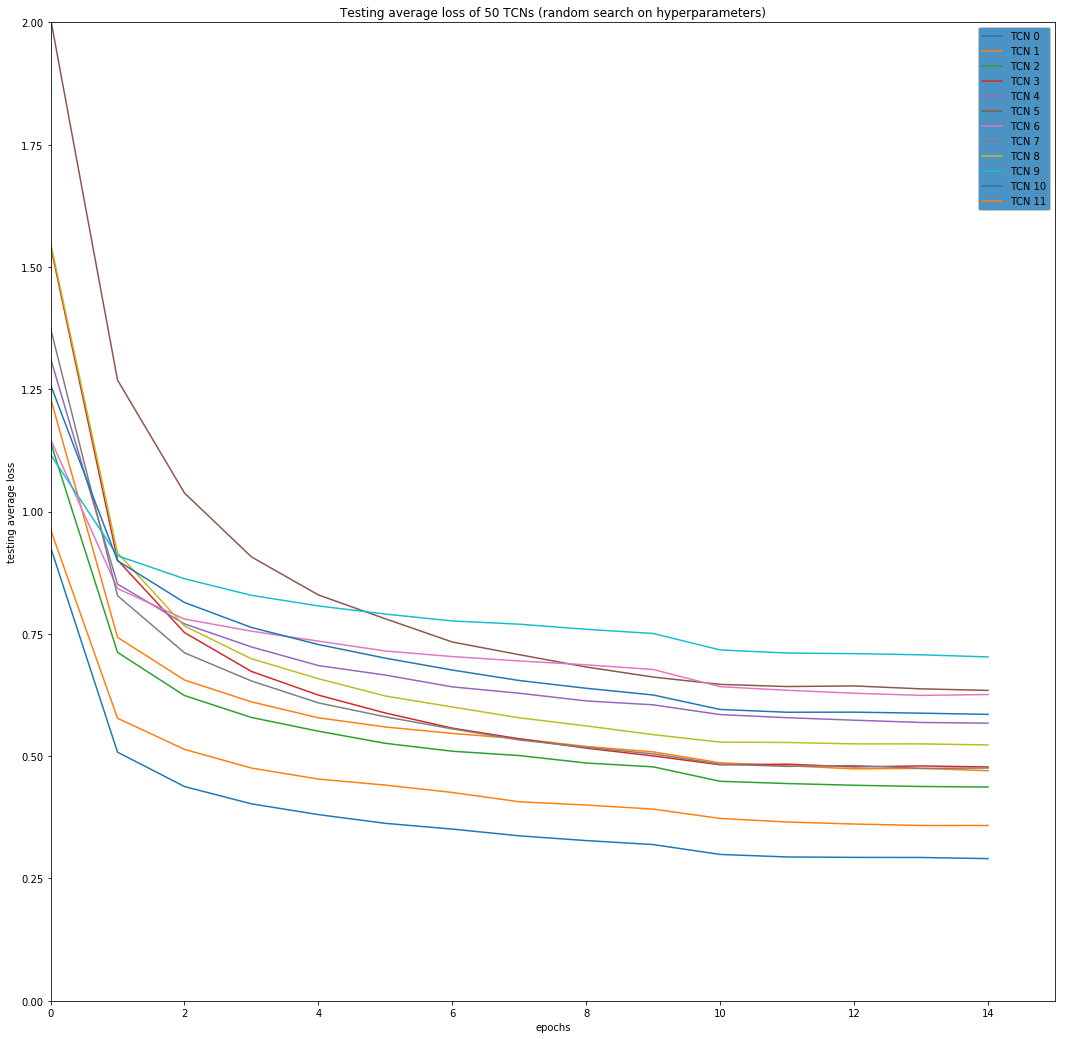

In [16]:
plotTrainLosses(scores, fsize=18, xlabel='epochs', ylabel='testing average loss',
                axis=[0, 15, 0, 2],
                title='Testing average loss of 50 TCNs (random search on hyperparameters)')

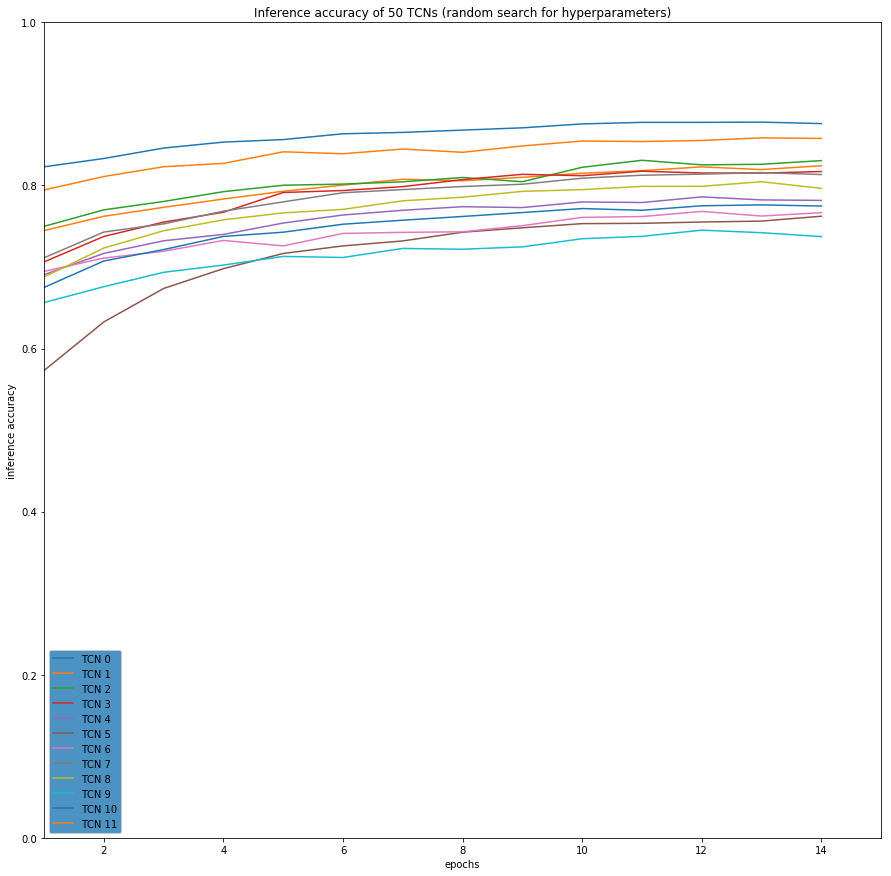

In [17]:
plotAccuracies(scores, fsize=15, acc_score=0.0, xlabel='epochs', 
               ylabel='inference accuracy', axis=[1, 15, 0, 1],
                title='Inference accuracy of 50 TCNs (random search for hyperparameters)')

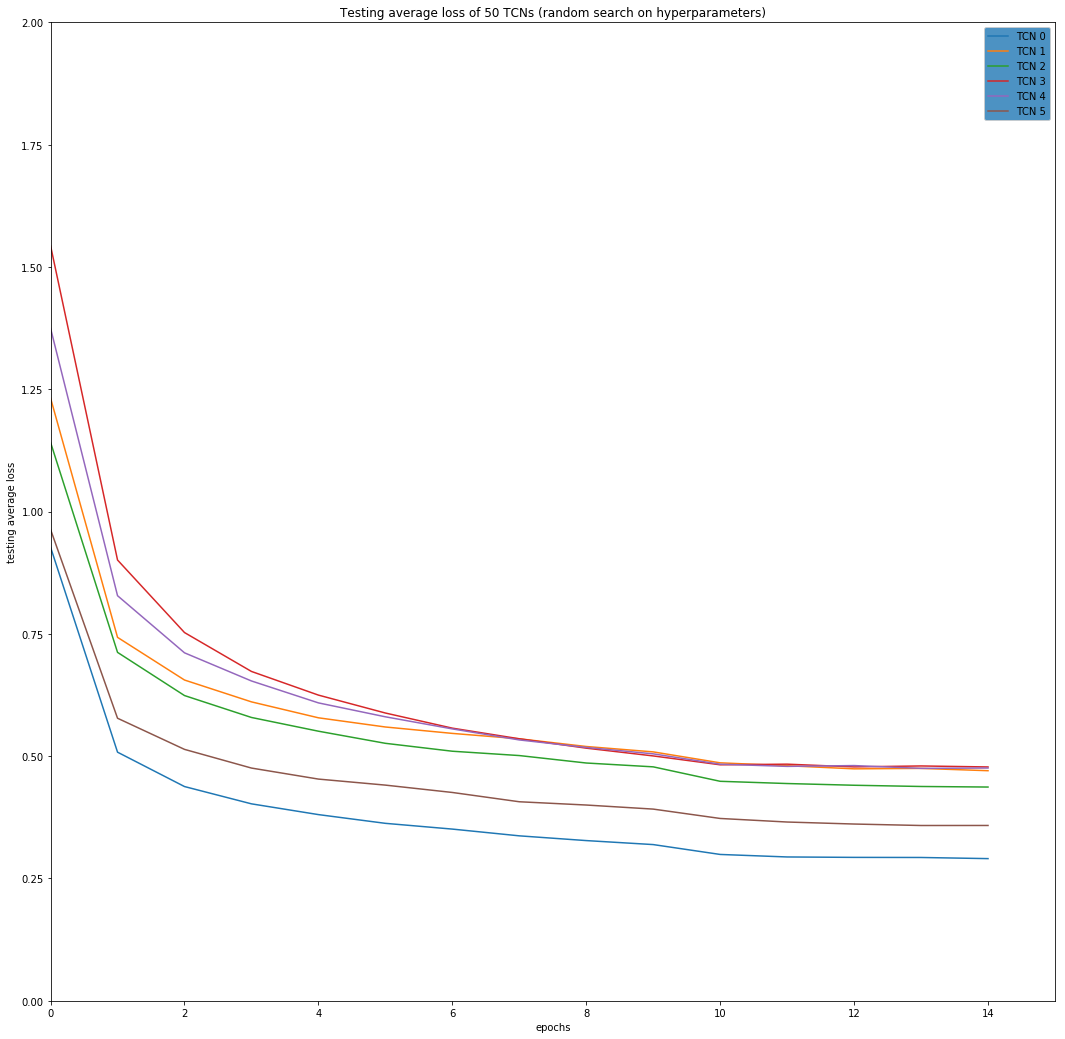

In [18]:
plotTrainLosses([score for score in scores if score['accuracies'][-1] > .80], fsize=18, 
                xlabel='epochs', ylabel='testing average loss', axis=[0, 15, 0, 2],
                title='Testing average loss of 50 TCNs (random search on hyperparameters)')

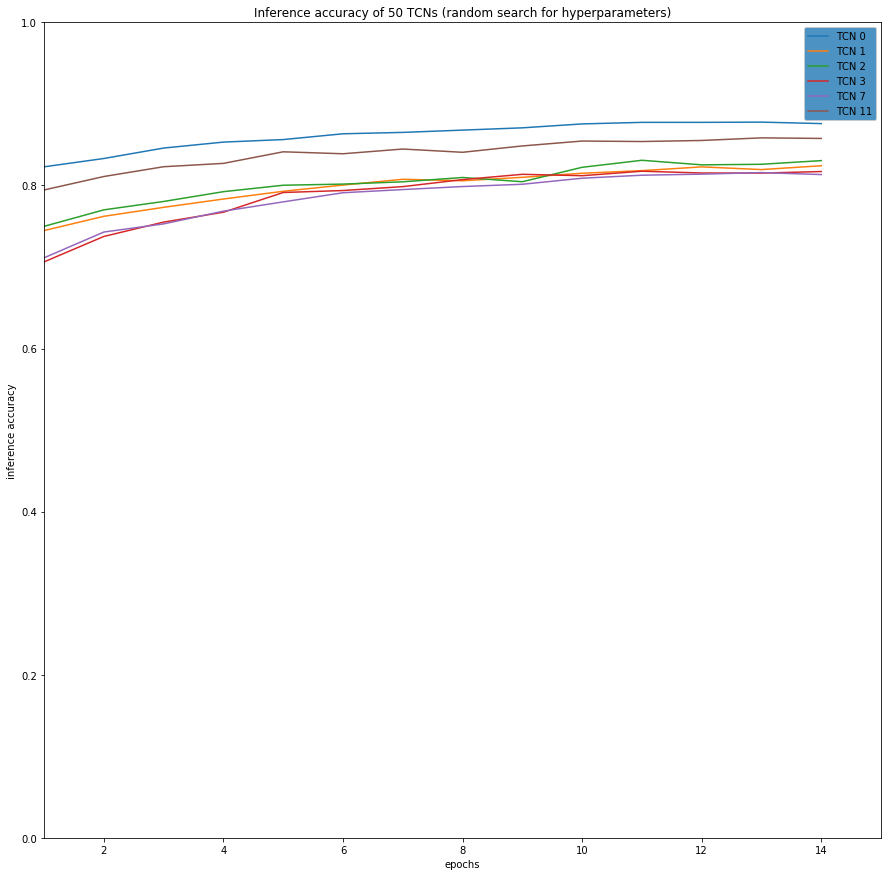

In [19]:
plotAccuracies(scores, fsize=15, acc_score=0.8, xlabel='epochs', 
               ylabel='inference accuracy', axis=[1, 15, 0, 1],
                title='Inference accuracy of 50 TCNs (random search for hyperparameters)')

In [463]:
# def runListParams(list_parameters):
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_channels = 1 # just one for the image
classes = ('T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
n_classes = len(classes) # 10 classes for fashion-mnist
log_interval = 100
seed = 1111
torch.manual_seed(seed)
permutee = False
input_channels = 1
seq_length = int(784 / input_channels)
steps = 0
cuda = True
scores = []
epochs = 5

for model_indx, parameters in enumerate(fake_list_params):
    print(parameters)
#     permute = torch.Tensor(np.random.permutation(784).astype(np.float64)).long()
#     permute = permute.to(device)

    train_loader, test_loader = data_generator('../data/fashion_mnist', parameters[0]['batch_size'])

    model = TCN(input_channels, n_classes, hidden_units=parameters[0]['nhid'], levels=parameters[0]['levels'], kernel_size=parameters[0]['ksize'], dropout=parameters[0]['dropout'])
    model = nn.DataParallel(model)
    model.to(device)
    steps = 0
    print("size of model => {0}".format(count_parameters(model)))
    lr = parameters[0]['lr']
    optimizer = getattr(optim, parameters[0]['optim'])(model.parameters(), lr=lr)
    accuracies_ = []
    train_losses_ = [[] for i in range(0, epochs)]
    test_losses_ = []
    file_name = './best_models/debug_tunning_model_{0}.pt'.format(model_indx)

    for epoch in range(1, epochs+1):
        trainTCN(epoch)
        test_losses_.append(testTCN())
        if epoch % 5 == 0: 
            print('Saving checkpoint for model.....')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.module.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses_,
                'test_losses': test_losses_,
                'accuracies': accuracies_,
                'curr_lr': lr,
            }, file_name)
        if epoch % 10 == 0:
            lr /= 10
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
    torch.save(model.module.state_dict(), file_name)
    scores.append({
        'accuracies': accuracies_,
        'train_losses': train_losses_,
        'test_losses': test_losses_,
    })
    print('Saved as %s' % file_name) 
save_obj(scores, './best_models/debug')

({'batch_size': 32, 'dropout': 0.054427468927671474, 'clip': -1, 'lr': 0.0001914417943740598, 'ksize': 5, 'levels': 8, 'optim': 'Adam', 'nhid': 24, 'epochs': 5}, 3)
size of model => 44386
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.282939	Steps: 79184
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.712290	Steps: 157584
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.193242	Steps: 235984
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.991922	Steps: 314384
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.900778	Steps: 392784
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.849686	Steps: 471184
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.787597	Steps: 549584
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.749365	Steps: 627984
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.724834	Steps: 706384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.688478	Steps: 784784
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.665505	Steps: 863184
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.650412	Steps: 941584
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.637055

Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.700500	Steps: 79184
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.086888	Steps: 157584
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.922996	Steps: 235984
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.827692	Steps: 314384

Test set: Average loss: 0.7820, Accuracy: 7108/10000 (71%)

Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.747131	Steps: 446880
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.722494	Steps: 525280
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.698472	Steps: 603680
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.669666	Steps: 682080

Test set: Average loss: 0.6992, Accuracy: 7389/10000 (73%)

Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.651949	Steps: 814576
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.646463	Steps: 892976
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.634304	Steps: 971376
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.618507	Steps: 1049776

Test set: Average loss: 0.6370, Accuracy: 7589/10000 (75%)

Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.601183

Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.234217	Steps: 79184
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.665588	Steps: 157584
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.365123	Steps: 235984
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.193374	Steps: 314384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.096761	Steps: 392784
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.015308	Steps: 471184
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.992800	Steps: 549584
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.941188	Steps: 627984
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.908602	Steps: 706384

Test set: Average loss: 0.9229, Accuracy: 6509/10000 (65%)

Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.908059	Steps: 814576
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.882795	Steps: 892976
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.867203	Steps: 971376
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.851318	Steps: 1049776
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.824288	Steps: 1128176
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.8

Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.733899	Steps: 3412752
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.720546	Steps: 3491152
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.735110	Steps: 3569552
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.717697	Steps: 3647952

Test set: Average loss: 0.7287, Accuracy: 7310/10000 (73%)

Saving checkpoint for model.....
Saved as ./best_models/debug_tunning_model_6.pt
({'batch_size': 64, 'dropout': 0.12912180440316612, 'clip': -1, 'lr': 0.00024394817806865665, 'ksize': 4, 'levels': 7, 'optim': 'Adam', 'nhid': 21, 'epochs': 5}, 38)
size of model => 23866
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.300854	Steps: 79184
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.804503	Steps: 157584
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.365986	Steps: 235984
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.184893	Steps: 314384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.079512	Steps: 392784
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.989611	Steps: 471184
Train Epoch: 1 [44800/60000

Train Epoch: 4 [28800/60000 (48%)]	Loss: 0.702710	Steps: 5116384
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.688441	Steps: 5194784
Train Epoch: 4 [35200/60000 (59%)]	Loss: 0.680527	Steps: 5273184
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.665024	Steps: 5351584
Train Epoch: 4 [41600/60000 (69%)]	Loss: 0.664162	Steps: 5429984
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.681965	Steps: 5508384
Train Epoch: 4 [48000/60000 (80%)]	Loss: 0.687540	Steps: 5586784
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.644727	Steps: 5665184
Train Epoch: 4 [54400/60000 (91%)]	Loss: 0.686607	Steps: 5743584
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.667285	Steps: 5821984

Test set: Average loss: 0.6715, Accuracy: 7474/10000 (74%)

Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.660290	Steps: 5959184
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.642318	Steps: 6037584
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.663599	Steps: 6115984
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.641389	Steps: 6194384
Train Epoch: 5 [16000/60000 (27%)

Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.761331	Steps: 2285360
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.757931	Steps: 2363760
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.754837	Steps: 2442160
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.756476	Steps: 2520560
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.765203	Steps: 2598960
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.736210	Steps: 2677360
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.726805	Steps: 2755760
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.737337	Steps: 2834160
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.736959	Steps: 2912560

Test set: Average loss: 0.7376, Accuracy: 7250/10000 (72%)

Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.722698	Steps: 3020752
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.721347	Steps: 3099152
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.732624	Steps: 3177552
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.717712	Steps: 3255952
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.730973	Steps: 3334352
Train Epoch: 5 [38400/60000 (64

In [22]:
scores = load_obj('./best_models/debug')
fake_list_params = new_list_params

for i, score in enumerate(scores):
    print(score['accuracies'][-1])
    print(fake_list_params[i])

0.853
({'batch_size': 32, 'dropout': 0.054427468927671474, 'clip': -1, 'lr': 0.0001914417943740598, 'ksize': 5, 'levels': 8, 'optim': 'Adam', 'nhid': 24, 'epochs': 5}, 3)
0.7672
({'batch_size': 128, 'dropout': 0.29048829641411367, 'clip': -1, 'lr': 0.0018362548306745871, 'ksize': 3, 'levels': 8, 'optim': 'Adam', 'nhid': 21, 'epochs': 5}, 9)
0.7837
({'batch_size': 128, 'dropout': 0.12466549806419837, 'clip': -1, 'lr': 0.0008805336423915327, 'ksize': 5, 'levels': 6, 'optim': 'Adam', 'nhid': 27, 'epochs': 5}, 13)
0.7784
({'batch_size': 32, 'dropout': 0.21961770142550557, 'clip': -1, 'lr': 6.0682595304921534e-05, 'ksize': 6, 'levels': 7, 'optim': 'Adam', 'nhid': 28, 'epochs': 5}, 24)
0.7431
({'batch_size': 64, 'dropout': 0.44103364548170304, 'clip': -1, 'lr': 0.0012018098639804324, 'ksize': 3, 'levels': 8, 'optim': 'Adam', 'nhid': 26, 'epochs': 5}, 28)
0.7233
({'batch_size': 128, 'dropout': 0.33816993096076015, 'clip': -1, 'lr': 0.00013921789162926014, 'ksize': 6, 'levels': 7, 'optim': 'Ad

In [45]:
scores_1 = load_obj('./best_models/manual_scores_1')
scores_1[0]['accuracies'][-1]

0.8829

In [44]:
scores_2 = load_obj('./best_models/manual_scores_0')
scores_2[0]['accuracies'][-1]

0.8949

In [144]:
paper_scores= [scores_1[0], scores_2[0]]
paper_scores[0]['train_losses'] = paper_scores[0]['training_loses']

for i, p in enumerate(paper_scores):
    print(p['accuracies'][-1])

# paper_scores[1]['train_losses']
# paper_scores[1]['train_losses'] = paper_scores[1].pop('train_loses')
# paper_scores[0]['train_losses'] = paper_scores[0].pop('training_loses')
# for i, score in enumerate(paper_scores):
#     print(score)
# #     if score['accuracies'][-1] >= acc_score:
# #         ax.plot([s for s in score['accuracies']], label="TCN {0}".format(i))

0.8829
0.8949


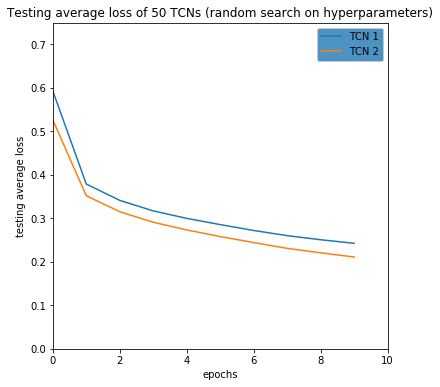

In [140]:
# [score for score in paper_scores if score['accuracies'][-1] > .80]
plotTrainLosses([score for score in paper_scores if score['accuracies'][-1] > .80], fsize=6, 
                xlabel='epochs', ylabel='testing average loss', axis=[0, 10, 0, 0.75],
                title='Testing average loss of 50 TCNs (random search on hyperparameters)')

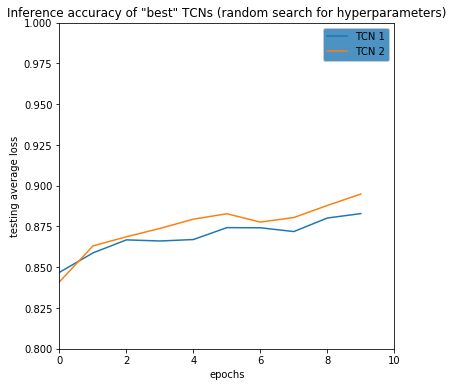

In [147]:
plotAccuracies(paper_scores, fsize=6, acc_score=0.25, xlabel='epochs', 
               ylabel='testing average loss', axis=[0, 10, 0.8, 1],
                title='Inference accuracy of "best" TCNs (random search for hyperparameters)')

In [179]:
paper_params = set_parameters(50, [64], dropout=[0.0, 0.0], clip=[-1, -1], lr=[-4, -2], 
                             ksize=[5, 13], levels=[6, 11], optim='Adam', nhid=[20, 31],
                             epochs=[5,6])

save_obj(paper_params, 'paper_parameters')
paper_params

[{'batch_size': 64,
  'dropout': 0.0,
  'clip': -1.0,
  'lr': 0.0018660497750821964,
  'ksize': 10,
  'levels': 8,
  'optim': 'Adam',
  'nhid': 27,
  'epochs': 5},
 {'batch_size': 64,
  'dropout': 0.0,
  'clip': -1.0,
  'lr': 0.0015298719814126683,
  'ksize': 6,
  'levels': 10,
  'optim': 'Adam',
  'nhid': 28,
  'epochs': 5},
 {'batch_size': 64,
  'dropout': 0.0,
  'clip': -1.0,
  'lr': 0.00624651963066543,
  'ksize': 11,
  'levels': 7,
  'optim': 'Adam',
  'nhid': 29,
  'epochs': 5},
 {'batch_size': 64,
  'dropout': 0.0,
  'clip': -1.0,
  'lr': 0.00027339239229661686,
  'ksize': 12,
  'levels': 7,
  'optim': 'Adam',
  'nhid': 21,
  'epochs': 5},
 {'batch_size': 64,
  'dropout': 0.0,
  'clip': -1.0,
  'lr': 0.0009337282316908241,
  'ksize': 6,
  'levels': 9,
  'optim': 'Adam',
  'nhid': 20,
  'epochs': 5},
 {'batch_size': 64,
  'dropout': 0.0,
  'clip': -1.0,
  'lr': 0.00012179821087315272,
  'ksize': 12,
  'levels': 10,
  'optim': 'Adam',
  'nhid': 28,
  'epochs': 5},
 {'batch_size': 

In [ ]:
# def runListParams(list_parameters):
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_channels = 1 # just one for the image
classes = ('T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
n_classes = len(classes) # 10 classes for fashion-mnist
log_interval = 100
seed = 1111
torch.manual_seed(seed)
permutee = False
input_channels = 1
seq_length = int(784 / input_channels)
steps = 0
cuda = True
scores = []
# epochs = 15

for model_indx, parameters in enumerate(paper_params):
    print(parameters)
#     permute = torch.Tensor(np.random.permutation(784).astype(np.float64)).long()
#     permute = permute.to(device)

    train_loader, test_loader = data_generator('../data/fashion_mnist', parameters['batch_size'])

    model = TCN(input_channels, n_classes, hidden_units=parameters['nhid'], levels=parameters['levels'], kernel_size=parameters['ksize'], dropout=parameters['dropout'])
    model = nn.DataParallel(model)
    model.to(device)
    steps = 0
    print("size of model => {0}".format(count_parameters(model)))
    lr = parameters['lr']
    optimizer = getattr(optim, parameters['optim'])(model.parameters(), lr=lr)
    accuracies_ = []
    train_losses_ = [0 for _ in range(len(clases))]
#     print(train_losses_)
    test_losses_ = []
    file_name = './best_models/paper_tunning{0}.pt'.format(model_indx)

    for epoch in range(1, parameters['epochs']+1):
        trainTCN(epoch)
        test_losses_.append(testTCN())
        if epoch % 5 == 0: 
            print('Saving checkpoint for model.....')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.module.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses_,
                'test_losses': test_losses_,
                'accuracies': accuracies_,
                'curr_lr': lr,
            }, file_name)
        if epoch % 10 == 0:
            lr /= 10
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
    torch.save(model.module.state_dict(), file_name)
    scores.append({
        'accuracies': accuracies_,
        'train_losses': train_losses_,
        'test_losses': test_losses_,
    })
    print('Saved as %s' % file_name) 
save_obj(scores, './best_models/paper_tunning')

{'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.0018660497750821964, 'ksize': 10, 'levels': 8, 'optim': 'Adam', 'nhid': 27, 'epochs': 5}
size of model => 110818
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.087552	Steps: 79184
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.647717	Steps: 157584
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.540767	Steps: 235984
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.486724	Steps: 314384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.450692	Steps: 392784
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.434605	Steps: 471184
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.414104	Steps: 549584
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.406314	Steps: 627984
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.391482	Steps: 706384

Test set: Average loss: 0.4236, Accuracy: 8416/10000 (84%)

Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.375996	Steps: 814576
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.370064	Steps: 892976
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.374983	Steps: 971376
Trai

Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.436301	Steps: 1441776

Test set: Average loss: 0.4752, Accuracy: 8338/10000 (83%)

Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.427025	Steps: 1549968
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.427478	Steps: 1628368
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.443328	Steps: 1706768
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.415666	Steps: 1785168
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.410544	Steps: 1863568
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.408970	Steps: 1941968
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.393427	Steps: 2020368
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.411572	Steps: 2098768
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.405340	Steps: 2177168

Test set: Average loss: 0.4349, Accuracy: 8451/10000 (84%)

Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.386359	Steps: 2285360
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.394052	Steps: 2363760
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.410249	Steps: 2442160
Train Epoch: 4 [25600/60000 (43%)]	

Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.319024	Steps: 2912560

Test set: Average loss: 0.3458, Accuracy: 8754/10000 (87%)

Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.304370	Steps: 3020752
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.290717	Steps: 3099152
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.305749	Steps: 3177552
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.288828	Steps: 3255952
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.300562	Steps: 3334352
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.293147	Steps: 3412752
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.286304	Steps: 3491152
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.290984	Steps: 3569552
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.301639	Steps: 3647952

Test set: Average loss: 0.3345, Accuracy: 8800/10000 (88%)

Saving checkpoint for model.....
Saved as ./best_models/paper_tunning4.pt
{'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.00012179821087315272, 'ksize': 12, 'levels': 10, 'optim': 'Adam', 'nhid': 28, 'epochs': 5}
size of

Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.557944	Steps: 471184
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.514703	Steps: 549584
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.500569	Steps: 627984
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.488106	Steps: 706384

Test set: Average loss: 0.5160, Accuracy: 8164/10000 (81%)

Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.462616	Steps: 814576
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.452947	Steps: 892976
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.454526	Steps: 971376
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.441061	Steps: 1049776
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.426757	Steps: 1128176
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.422563	Steps: 1206576
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.407706	Steps: 1284976
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.407475	Steps: 1363376
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.409593	Steps: 1441776

Test set: Average loss: 0.4256, Accuracy: 8452/10000 (84%)

Train Epoch: 3 [6400/60000 (11%)]	Loss: 0

Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.419036	Steps: 2020368
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.424023	Steps: 2098768
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.425296	Steps: 2177168

Test set: Average loss: 0.4451, Accuracy: 8423/10000 (84%)

Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.404671	Steps: 2285360
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.409924	Steps: 2363760
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.414587	Steps: 2442160
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.395610	Steps: 2520560
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.395834	Steps: 2598960
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.396578	Steps: 2677360
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.381845	Steps: 2755760
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.392245	Steps: 2834160
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.395407	Steps: 2912560

Test set: Average loss: 0.4109, Accuracy: 8551/10000 (85%)

Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.369467	Steps: 3020752
Train Epoch: 5 [12800/60000 (21%)]	

Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.285994	Steps: 3491152
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.284227	Steps: 3569552
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.299137	Steps: 3647952

Test set: Average loss: 0.3470, Accuracy: 8701/10000 (87%)

Saving checkpoint for model.....
Saved as ./best_models/paper_tunning11.pt
{'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.000540490539221378, 'ksize': 12, 'levels': 7, 'optim': 'Adam', 'nhid': 30, 'epochs': 5}
size of model => 141970
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.320867	Steps: 79184
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.719457	Steps: 157584
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.623688	Steps: 235984
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.548543	Steps: 314384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.495350	Steps: 392784
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.484353	Steps: 471184
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.446280	Steps: 549584
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.445790	Step

Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.536243	Steps: 1049776
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.521400	Steps: 1128176
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.511573	Steps: 1206576
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.492528	Steps: 1284976
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.491587	Steps: 1363376
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.488011	Steps: 1441776

Test set: Average loss: 0.4878, Accuracy: 8224/10000 (82%)

Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.457965	Steps: 1549968
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.462429	Steps: 1628368
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.471702	Steps: 1706768
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.456693	Steps: 1785168
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.451531	Steps: 1863568
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.447566	Steps: 1941968
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.430691	Steps: 2020368
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.439573	Steps: 2098768
Train Epoch: 3 [57600/60000 (9

Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.328809	Steps: 2520560
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.330730	Steps: 2598960
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.331987	Steps: 2677360
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.322636	Steps: 2755760
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.329588	Steps: 2834160
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.337110	Steps: 2912560

Test set: Average loss: 0.3478, Accuracy: 8742/10000 (87%)

Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.313938	Steps: 3020752
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.313123	Steps: 3099152
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.324077	Steps: 3177552
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.307406	Steps: 3255952
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.312111	Steps: 3334352
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.314562	Steps: 3412752
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.304613	Steps: 3491152
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.310709	Steps: 3569552
Train Epoch: 5 [57600/60000 (9

Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.265762	Steps: 79184
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.672070	Steps: 157584
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.592810	Steps: 235984
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.510374	Steps: 314384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.488706	Steps: 392784
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.464169	Steps: 471184
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.428049	Steps: 549584
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.429718	Steps: 627984
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.412340	Steps: 706384

Test set: Average loss: 0.4465, Accuracy: 8378/10000 (83%)

Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.387932	Steps: 814576
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.385201	Steps: 892976
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.391694	Steps: 971376
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.364866	Steps: 1049776
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.364709	Steps: 1128176
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.3

Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.449383	Steps: 1628368
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.454586	Steps: 1706768
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.446055	Steps: 1785168
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.439708	Steps: 1863568
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.440528	Steps: 1941968
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.419229	Steps: 2020368
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.428758	Steps: 2098768
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.430517	Steps: 2177168

Test set: Average loss: 0.4330, Accuracy: 8419/10000 (84%)

Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.408303	Steps: 2285360
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.404447	Steps: 2363760
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.409949	Steps: 2442160
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.402126	Steps: 2520560
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.405475	Steps: 2598960
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.402458	Steps: 2677360
Train Epoch: 4 [44800/60000 (7

Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.548433	Steps: 3099152
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.569135	Steps: 3177552
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.556464	Steps: 3255952
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.550833	Steps: 3334352
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.531784	Steps: 3412752
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.533064	Steps: 3491152
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.537570	Steps: 3569552
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.544027	Steps: 3647952

Test set: Average loss: 0.5485, Accuracy: 7941/10000 (79%)

Saving checkpoint for model.....
Saved as ./best_models/paper_tunning23.pt
{'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.00011173884399839355, 'ksize': 6, 'levels': 10, 'optim': 'Adam', 'nhid': 30, 'epochs': 5}
size of model => 104350
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.228695	Steps: 79184
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.221106	Steps: 157584
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.8545

Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.496596	Steps: 706384

Test set: Average loss: 0.4941, Accuracy: 8209/10000 (82%)

Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.464784	Steps: 814576
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.465369	Steps: 892976
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.455574	Steps: 971376
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.436029	Steps: 1049776
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.428839	Steps: 1128176
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.418081	Steps: 1206576
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.401640	Steps: 1284976
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.406119	Steps: 1363376
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.409576	Steps: 1441776

Test set: Average loss: 0.4216, Accuracy: 8483/10000 (84%)

Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.392416	Steps: 1549968
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.393134	Steps: 1628368
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.395737	Steps: 1706768
Train Epoch: 3 [25600/60000 (43%)]	Loss

Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.441306	Steps: 2177168


In [296]:
paper_scores = load_obj('./best_models/paper_tunning')
for score in paper_scores:
    score['train_losses'] = score['train_losses'][:5]
# (paper_scores[0]['train_losses'][:5])
for i, score in enumerate(paper_scores):
    for y, s in enumerate(score['train_losses']):
#         print(i, y, s/10000)
        paper_scores[i]['train_losses'][y] = s / 10000

# [p['train_losses'] for p in paper_scores]
paper_scores

[{'accuracies': [0.8416, 0.8633, 0.8744, 0.8753, 0.8784],
  'train_losses': [2.617222071991861,
   1.6436933198869228,
   1.4687913433745503,
   1.3538137732848525,
   1.2636924844533206],
  'test_losses': [0.4236077703475952,
   0.37016609728336336,
   0.3458720648765564,
   0.33803563356399535,
   0.332366092467308]},
 {'accuracies': [0.8458, 0.859, 0.8646, 0.8708, 0.879],
  'train_losses': [2.8101649002462628,
   1.6797257449313998,
   1.4872887846074998,
   1.3799817919619382,
   1.2951527880556881],
  'test_losses': [0.4251970455169678,
   0.371588166308403,
   0.3748097341299057,
   0.3544353180170059,
   0.3319410354375839]},
 {'accuracies': [0.8118, 0.8338, 0.8451, 0.8496, 0.8532],
  'train_losses': [3.890849090513587,
   2.1677751088783146,
   1.9154810138881206,
   1.7769062185168267,
   1.6713088854238392],
  'test_losses': [0.5066852074623108,
   0.4752259083986282,
   0.4349177855730057,
   0.416025159907341,
   0.40898916907310484]},
 {'accuracies': [0.8028, 0.8466, 0.857

In [310]:
paper_parameters = load_obj('paper_parameters')
len(paper_parameters)
show_models_results(paper_scores, paper_parameters)

Model 1
Parameters => {'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.0018660497750821964, 'ksize': 10, 'levels': 8, 'optim': 'Adam', 'nhid': 27, 'epochs': 5}
Inference accuracy => 0.8784
Train losses => [2.617222071991861, 1.6436933198869228, 1.4687913433745503, 1.3538137732848525, 1.2636924844533206]
Model 2
Parameters => {'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.0015298719814126683, 'ksize': 6, 'levels': 10, 'optim': 'Adam', 'nhid': 28, 'epochs': 5}
Inference accuracy => 0.879
Train losses => [2.8101649002462628, 1.6797257449313998, 1.4872887846074998, 1.3799817919619382, 1.2951527880556881]
Model 3
Parameters => {'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.00624651963066543, 'ksize': 11, 'levels': 7, 'optim': 'Adam', 'nhid': 29, 'epochs': 5}
Inference accuracy => 0.8532
Train losses => [3.890849090513587, 2.1677751088783146, 1.9154810138881206, 1.7769062185168267, 1.6713088854238392]
Model 4
Parameters => {'batch_size': 64, 'dropout': 0.0, 'clip'

In [291]:
# plotTrainLosses(paper_scores, fsize=12, 
#                 xlabel='epochs', ylabel='testing average loss', axis=[0, 5, 0, 6],
#                 title='Testing average loss of 50 TCNs (random search on hyperparameters)')

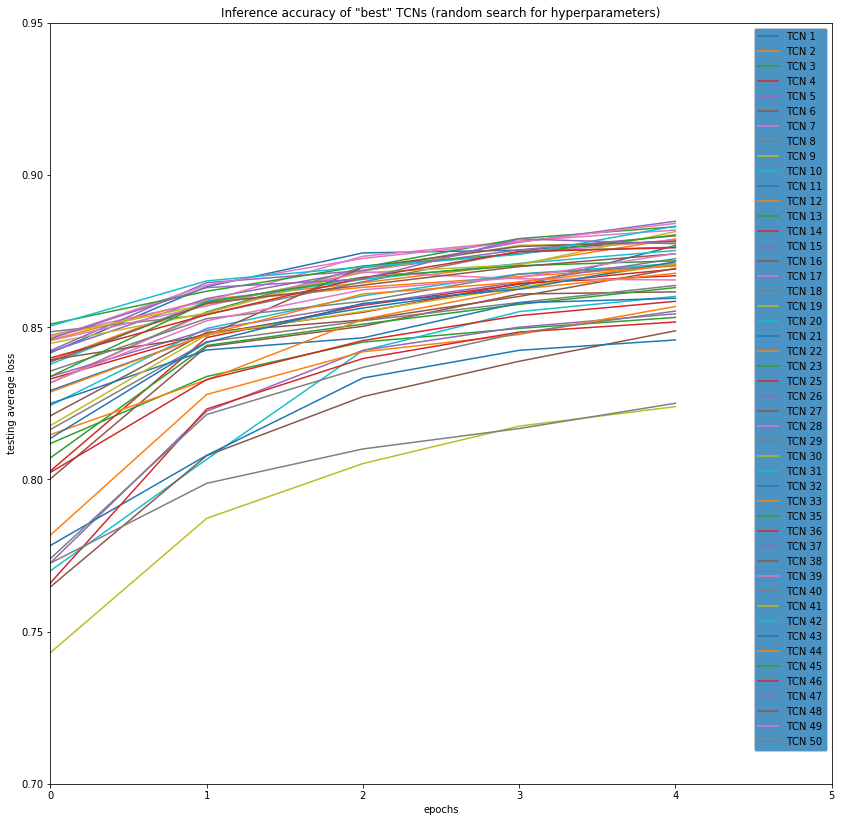

In [304]:
plotAccuracies(paper_scores, fsize=14, acc_score=0.80, xlabel='epochs', 
               ylabel='testing average loss', axis=[0, 5, 0.70, 0.95],
                title='Inference accuracy of "best" TCNs (random search for hyperparameters)')

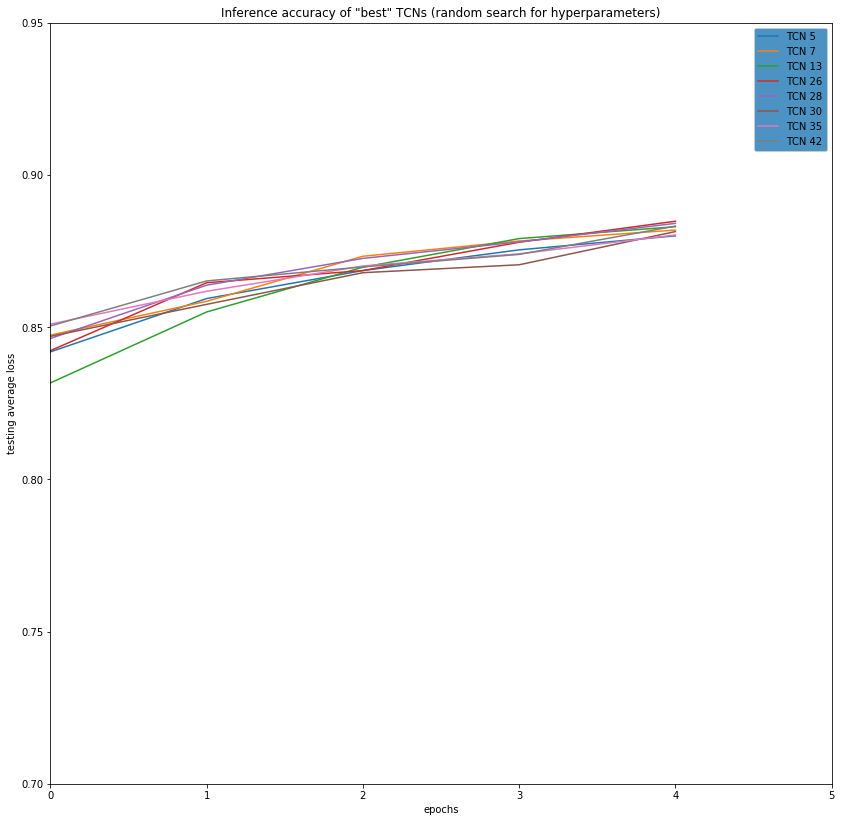

In [305]:
plotAccuracies(paper_scores, fsize=14, acc_score=0.88, xlabel='epochs', 
               ylabel='testing average loss', axis=[0, 5, 0.70, 0.95],
                title='Inference accuracy of "best" TCNs (random search for hyperparameters)')

In [326]:
# paper_parameters = [paper_parameters[i] for i, p in enumerate(paper_scores) if p['accuracies'][-1] >= 0.88]
# print(len(paper_parameters))
for i, p in enumerate(paper_parameters):
    p['epochs'] = 20
paper_parameters

[{'batch_size': 64,
  'dropout': 0.0,
  'clip': -1.0,
  'lr': 0.0009337282316908241,
  'ksize': 6,
  'levels': 9,
  'optim': 'Adam',
  'nhid': 20,
  'epochs': 20},
 {'batch_size': 64,
  'dropout': 0.0,
  'clip': -1.0,
  'lr': 0.003890087021499219,
  'ksize': 8,
  'levels': 9,
  'optim': 'Adam',
  'nhid': 25,
  'epochs': 20},
 {'batch_size': 64,
  'dropout': 0.0,
  'clip': -1.0,
  'lr': 0.000540490539221378,
  'ksize': 12,
  'levels': 7,
  'optim': 'Adam',
  'nhid': 30,
  'epochs': 20},
 {'batch_size': 64,
  'dropout': 0.0,
  'clip': -1.0,
  'lr': 0.0006393446641262778,
  'ksize': 10,
  'levels': 10,
  'optim': 'Adam',
  'nhid': 26,
  'epochs': 20},
 {'batch_size': 64,
  'dropout': 0.0,
  'clip': -1.0,
  'lr': 0.001116023780748241,
  'ksize': 7,
  'levels': 8,
  'optim': 'Adam',
  'nhid': 28,
  'epochs': 20},
 {'batch_size': 64,
  'dropout': 0.0,
  'clip': -1.0,
  'lr': 0.002037075086074332,
  'ksize': 6,
  'levels': 10,
  'optim': 'Adam',
  'nhid': 27,
  'epochs': 20},
 {'batch_size': 

In [328]:
# def runListParams(list_parameters):
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_channels = 1 # just one for the image
classes = ('T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
n_classes = len(classes) # 10 classes for fashion-mnist
log_interval = 100
seed = 1111
torch.manual_seed(seed)
permutee = False
input_channels = 1
seq_length = int(784 / input_channels)
steps = 0
cuda = True
scores = []
# epochs = 15

for model_indx, parameters in enumerate(paper_parameters):
    print(parameters)
#     permute = torch.Tensor(np.random.permutation(784).astype(np.float64)).long()
#     permute = permute.to(device)

    train_loader, test_loader = data_generator('../data/fashion_mnist', parameters['batch_size'])

    model = TCN(input_channels, n_classes, hidden_units=parameters['nhid'], levels=parameters['levels'], kernel_size=parameters['ksize'], dropout=parameters['dropout'])
    model = nn.DataParallel(model)
    model.to(device)
    steps = 0
    print("size of model => {0}".format(count_parameters(model)))
    lr = parameters['lr']
    optimizer = getattr(optim, parameters['optim'])(model.parameters(), lr=lr)
    accuracies_ = []
    train_losses_ = [[] for i in range(0, 20)]
#     print(train_losses_)
    test_losses_ = []
    file_name = './best_models/paper_tunning_second_{0}.pt'.format(model_indx)

    for epoch in range(1, parameters['epochs']+1):
        trainTCN(epoch)
        test_losses_.append(testTCN())
        if epoch % 5 == 0: 
            print('Saving checkpoint for model.....')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.module.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses_,
                'test_losses': test_losses_,
                'accuracies': accuracies_,
                'curr_lr': lr,
            }, file_name)
        if epoch % 10 == 0:
            lr /= 10
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
    torch.save(model.module.state_dict(), file_name)
    scores.append({
        'accuracies': accuracies_,
        'train_losses': train_losses_,
        'test_losses': test_losses_,
    })
    print('Saved as %s' % file_name) 
save_obj(scores, './best_models/paper_tunning_second')

{'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.0009337282316908241, 'ksize': 6, 'levels': 9, 'optim': 'Adam', 'nhid': 20, 'epochs': 20}
size of model => 41890
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.471796	Steps: 79184
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.713466	Steps: 157584
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.610093	Steps: 235984
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.541192	Steps: 314384
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.505133	Steps: 392784
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.488236	Steps: 471184
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.454119	Steps: 549584
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.454454	Steps: 627984
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.436425	Steps: 706384

Test set: Average loss: 0.4734, Accuracy: 8294/10000 (82%)

Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.416889	Steps: 814576
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.408280	Steps: 892976
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.408965	Steps: 971376
Train

Train Epoch: 13 [32000/60000 (53%)]	Loss: 0.202929	Steps: 9217488
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.201449	Steps: 9295888
Train Epoch: 13 [44800/60000 (75%)]	Loss: 0.192464	Steps: 9374288
Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.191763	Steps: 9452688
Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.195639	Steps: 9531088

Test set: Average loss: 0.2782, Accuracy: 9008/10000 (90%)

Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.197136	Steps: 9639280
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.193553	Steps: 9717680
Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.212313	Steps: 9796080
Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.198568	Steps: 9874480
Train Epoch: 14 [32000/60000 (53%)]	Loss: 0.199446	Steps: 9952880
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.197893	Steps: 10031280
Train Epoch: 14 [44800/60000 (75%)]	Loss: 0.189242	Steps: 10109680
Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.188650	Steps: 10188080
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.193547	Steps: 10266480

Test set: A

Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.287673	Steps: 3412752
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.270900	Steps: 3491152
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.281541	Steps: 3569552
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.284999	Steps: 3647952

Test set: Average loss: 0.3313, Accuracy: 8793/10000 (87%)

Saving checkpoint for model.....
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.264332	Steps: 3756144
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.263324	Steps: 3834544
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.280568	Steps: 3912944
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.260362	Steps: 3991344
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.268240	Steps: 4069744
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.271793	Steps: 4148144
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.257426	Steps: 4226544
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.260440	Steps: 4304944
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.272212	Steps: 4383344

Test set: Average loss: 0.3249, Accuracy: 8829/10000 (88%)

T


Test set: Average loss: 0.3023, Accuracy: 9023/10000 (90%)

Train Epoch: 18 [6400/60000 (11%)]	Loss: 0.148070	Steps: 12580848
Train Epoch: 18 [12800/60000 (21%)]	Loss: 0.147763	Steps: 12659248
Train Epoch: 18 [19200/60000 (32%)]	Loss: 0.157659	Steps: 12737648
Train Epoch: 18 [25600/60000 (43%)]	Loss: 0.146723	Steps: 12816048
Train Epoch: 18 [32000/60000 (53%)]	Loss: 0.152348	Steps: 12894448
Train Epoch: 18 [38400/60000 (64%)]	Loss: 0.154144	Steps: 12972848
Train Epoch: 18 [44800/60000 (75%)]	Loss: 0.141753	Steps: 13051248
Train Epoch: 18 [51200/60000 (85%)]	Loss: 0.138462	Steps: 13129648
Train Epoch: 18 [57600/60000 (96%)]	Loss: 0.139441	Steps: 13208048

Test set: Average loss: 0.3058, Accuracy: 9021/10000 (90%)

Train Epoch: 19 [6400/60000 (11%)]	Loss: 0.143753	Steps: 13316240
Train Epoch: 19 [12800/60000 (21%)]	Loss: 0.144028	Steps: 13394640
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.153744	Steps: 13473040
Train Epoch: 19 [25600/60000 (43%)]	Loss: 0.142805	Steps: 13551440
Train Epo

Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.244579	Steps: 6854512
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.233819	Steps: 6932912
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.233587	Steps: 7011312
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.223539	Steps: 7089712
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.223706	Steps: 7168112
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.225120	Steps: 7246512
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.241280	Steps: 7324912

Test set: Average loss: 0.3092, Accuracy: 8899/10000 (88%)

Saving checkpoint for model.....
Train Epoch: 11 [6400/60000 (11%)]	Loss: 0.224506	Steps: 7433104
Train Epoch: 11 [12800/60000 (21%)]	Loss: 0.210243	Steps: 7511504
Train Epoch: 11 [19200/60000 (32%)]	Loss: 0.222385	Steps: 7589904
Train Epoch: 11 [25600/60000 (43%)]	Loss: 0.206037	Steps: 7668304
Train Epoch: 11 [32000/60000 (53%)]	Loss: 0.209217	Steps: 7746704
Train Epoch: 11 [38400/60000 (64%)]	Loss: 0.199164	Steps: 7825104
Train Epoch: 11 [44800/60000 (75%)]	Loss: 0.19259

Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.388314	Steps: 971376
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.368051	Steps: 1049776
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.360917	Steps: 1128176
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.357565	Steps: 1206576
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.341530	Steps: 1284976
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.356772	Steps: 1363376
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.355381	Steps: 1441776

Test set: Average loss: 0.3803, Accuracy: 8603/10000 (86%)

Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.340937	Steps: 1549968
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.329554	Steps: 1628368
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.340473	Steps: 1706768
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.329285	Steps: 1785168
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.323707	Steps: 1863568
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.321062	Steps: 1941968
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.306982	Steps: 2020368
Train Epoch: 3 [51200/60000 (85

Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.161738	Steps: 10266480

Test set: Average loss: 0.2668, Accuracy: 9088/10000 (90%)

Train Epoch: 15 [6400/60000 (11%)]	Loss: 0.163471	Steps: 10374672
Train Epoch: 15 [12800/60000 (21%)]	Loss: 0.155395	Steps: 10453072
Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.167366	Steps: 10531472
Train Epoch: 15 [25600/60000 (43%)]	Loss: 0.165538	Steps: 10609872
Train Epoch: 15 [32000/60000 (53%)]	Loss: 0.167653	Steps: 10688272
Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.159051	Steps: 10766672
Train Epoch: 15 [44800/60000 (75%)]	Loss: 0.151363	Steps: 10845072
Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.158566	Steps: 10923472
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.158010	Steps: 11001872

Test set: Average loss: 0.2674, Accuracy: 9090/10000 (90%)

Saving checkpoint for model.....
Train Epoch: 16 [6400/60000 (11%)]	Loss: 0.159375	Steps: 11110064
Train Epoch: 16 [12800/60000 (21%)]	Loss: 0.151655	Steps: 11188464
Train Epoch: 16 [19200/60000 (32%)]	Loss: 0


Test set: Average loss: 0.3151, Accuracy: 8846/10000 (88%)

Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.255683	Steps: 4491536
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.242928	Steps: 4569936
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.254597	Steps: 4648336
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.244307	Steps: 4726736
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.254188	Steps: 4805136
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.254313	Steps: 4883536
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.242679	Steps: 4961936
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.247683	Steps: 5040336
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.252828	Steps: 5118736

Test set: Average loss: 0.3099, Accuracy: 8851/10000 (88%)

Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.242153	Steps: 5226928
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.228973	Steps: 5305328
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.240750	Steps: 5383728
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.232516	Steps: 5462128
Train Epoch: 8 [32000/60000 (53%)]	

Train Epoch: 19 [32000/60000 (53%)]	Loss: 0.150979	Steps: 13629840
Train Epoch: 19 [38400/60000 (64%)]	Loss: 0.146384	Steps: 13708240
Train Epoch: 19 [44800/60000 (75%)]	Loss: 0.139609	Steps: 13786640
Train Epoch: 19 [51200/60000 (85%)]	Loss: 0.141451	Steps: 13865040
Train Epoch: 19 [57600/60000 (96%)]	Loss: 0.144071	Steps: 13943440

Test set: Average loss: 0.2737, Accuracy: 9081/10000 (90%)

Train Epoch: 20 [6400/60000 (11%)]	Loss: 0.144991	Steps: 14051632
Train Epoch: 20 [12800/60000 (21%)]	Loss: 0.139078	Steps: 14130032
Train Epoch: 20 [19200/60000 (32%)]	Loss: 0.151527	Steps: 14208432
Train Epoch: 20 [25600/60000 (43%)]	Loss: 0.138211	Steps: 14286832
Train Epoch: 20 [32000/60000 (53%)]	Loss: 0.148057	Steps: 14365232
Train Epoch: 20 [38400/60000 (64%)]	Loss: 0.143269	Steps: 14443632
Train Epoch: 20 [44800/60000 (75%)]	Loss: 0.136511	Steps: 14522032
Train Epoch: 20 [51200/60000 (85%)]	Loss: 0.138585	Steps: 14600432
Train Epoch: 20 [57600/60000 (96%)]	Loss: 0.141155	Steps: 14678832

T

Train Epoch: 11 [44800/60000 (75%)]	Loss: 0.172703	Steps: 7903504
Train Epoch: 11 [51200/60000 (85%)]	Loss: 0.167301	Steps: 7981904
Train Epoch: 11 [57600/60000 (96%)]	Loss: 0.153394	Steps: 8060304

Test set: Average loss: 0.2721, Accuracy: 9069/10000 (90%)

Train Epoch: 12 [6400/60000 (11%)]	Loss: 0.169782	Steps: 8168496
Train Epoch: 12 [12800/60000 (21%)]	Loss: 0.158854	Steps: 8246896
Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.179003	Steps: 8325296
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.164873	Steps: 8403696
Train Epoch: 12 [32000/60000 (53%)]	Loss: 0.172578	Steps: 8482096
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.160870	Steps: 8560496
Train Epoch: 12 [44800/60000 (75%)]	Loss: 0.161935	Steps: 8638896
Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.158137	Steps: 8717296
Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.148087	Steps: 8795696

Test set: Average loss: 0.2741, Accuracy: 9081/10000 (90%)

Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.162025	Steps: 8903888
Train Epoch: 13 [12800

Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.349449	Steps: 2098768
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.350318	Steps: 2177168

Test set: Average loss: 0.3916, Accuracy: 8585/10000 (85%)

Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.328901	Steps: 2285360
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.331721	Steps: 2363760
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.341379	Steps: 2442160
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.327781	Steps: 2520560
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.331966	Steps: 2598960
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.320251	Steps: 2677360
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.311079	Steps: 2755760
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.323483	Steps: 2834160
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.332418	Steps: 2912560

Test set: Average loss: 0.3646, Accuracy: 8671/10000 (86%)

Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.311664	Steps: 3020752
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.305925	Steps: 3099152
Train Epoch: 5 [19200/60000 (32%)]	

Train Epoch: 16 [19200/60000 (32%)]	Loss: 0.213217	Steps: 11266864
Train Epoch: 16 [25600/60000 (43%)]	Loss: 0.204515	Steps: 11345264
Train Epoch: 16 [32000/60000 (53%)]	Loss: 0.211352	Steps: 11423664
Train Epoch: 16 [38400/60000 (64%)]	Loss: 0.198515	Steps: 11502064
Train Epoch: 16 [44800/60000 (75%)]	Loss: 0.196409	Steps: 11580464
Train Epoch: 16 [51200/60000 (85%)]	Loss: 0.196291	Steps: 11658864
Train Epoch: 16 [57600/60000 (96%)]	Loss: 0.199870	Steps: 11737264

Test set: Average loss: 0.3062, Accuracy: 8917/10000 (89%)

Train Epoch: 17 [6400/60000 (11%)]	Loss: 0.198642	Steps: 11845456
Train Epoch: 17 [12800/60000 (21%)]	Loss: 0.190164	Steps: 11923856
Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.210213	Steps: 12002256
Train Epoch: 17 [25600/60000 (43%)]	Loss: 0.201580	Steps: 12080656
Train Epoch: 17 [32000/60000 (53%)]	Loss: 0.208900	Steps: 12159056
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.195374	Steps: 12237456
Train Epoch: 17 [44800/60000 (75%)]	Loss: 0.193827	Steps: 12315856
Tr

Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.233747	Steps: 5540528
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.227040	Steps: 5618928
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.218246	Steps: 5697328
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.231660	Steps: 5775728
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.235013	Steps: 5854128

Test set: Average loss: 0.3195, Accuracy: 8810/10000 (88%)

Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.221882	Steps: 5962320
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.208571	Steps: 6040720
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.228858	Steps: 6119120
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.221780	Steps: 6197520
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.224390	Steps: 6275920
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.216602	Steps: 6354320
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.207739	Steps: 6432720
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.222995	Steps: 6511120
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.229150	Steps: 6589520

Test set: Average loss: 0.308

Train Epoch: 20 [57600/60000 (96%)]	Loss: 0.133065	Steps: 14678832

Test set: Average loss: 0.2714, Accuracy: 9114/10000 (91%)

Saving checkpoint for model.....
Saved as ./best_models/paper_tunning_second_7.pt


In [329]:
paper_scores = load_obj('./best_models/paper_tunning_second')
paper_scores

[{'accuracies': [0.8294,
   0.8551,
   0.8601,
   0.8708,
   0.873,
   0.8764,
   0.8809,
   0.8826,
   0.8819,
   0.8847,
   0.8986,
   0.9001,
   0.9008,
   0.9004,
   0.9002,
   0.9002,
   0.9005,
   0.9006,
   0.9011,
   0.9011],
  'train_losses': [[1.4717959296703338,
    0.7134663814306259,
    0.6100925070047378,
    0.5411915588378906,
    0.5051327918469906,
    0.48823591738939287,
    0.45411949694156645,
    0.4544535876810551,
    0.43642450973391533],
   [0.4168892878293991,
    0.4082800018787384,
    0.40896468415856363,
    0.383901806473732,
    0.38749098539352417,
    0.3862010709941387,
    0.3674617527425289,
    0.3746110101044178,
    0.37190535098314287],
   [0.3623294360935688,
    0.35467916339635847,
    0.36095019325613975,
    0.3452064549922943,
    0.3500968238711357,
    0.3497946211695671,
    0.3284379683434963,
    0.34122943088412283,
    0.34622508093714716],
   [0.3299992449581623,
    0.32569441080093386,
    0.3327439448237419,
    0.32181599110

In [330]:
### best score

In [333]:
bst = -1
# paper_parameters
# for score in paper_scores
print(len(paper_scores))
print(len(paper_parameters))

8
8


In [334]:
for i, score in enumerate(paper_scores):
    print(paper_parameters[i])
    print(score['accuracies'][-1])

{'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.0009337282316908241, 'ksize': 6, 'levels': 9, 'optim': 'Adam', 'nhid': 20, 'epochs': 20}
0.9011
{'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.003890087021499219, 'ksize': 8, 'levels': 9, 'optim': 'Adam', 'nhid': 25, 'epochs': 20}
0.9026
{'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.000540490539221378, 'ksize': 12, 'levels': 7, 'optim': 'Adam', 'nhid': 30, 'epochs': 20}
0.9071
{'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.0006393446641262778, 'ksize': 10, 'levels': 10, 'optim': 'Adam', 'nhid': 26, 'epochs': 20}
0.9092
{'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.001116023780748241, 'ksize': 7, 'levels': 8, 'optim': 'Adam', 'nhid': 28, 'epochs': 20}
0.9087
{'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.002037075086074332, 'ksize': 6, 'levels': 10, 'optim': 'Adam', 'nhid': 27, 'epochs': 20}
0.9063
{'batch_size': 64, 'dropout': 0.0, 'clip': -1.0, 'lr': 0.005869558995974768, 'ksiz

In [ ]:
'./best_models/paper_tunning_second_7.pt'